In [83]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('figure', figsize=(20, 12))

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

import lddecode_core as ldd

# Notebook-only functions go here

# Draws a uint16 image, downscaled to uint8
def draw_raw_bwimage(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:

def GetBlankVBI():
    rv = {
        'raw': [None, None, None, None, None, None],
        'discType': None,
        'isLeadIn': None,
        'isLeadOut': None,
        'userCode': None,
        'clvMinutes': None,
        'clvSeconds': None,
        'clvPictureNumber': None,
        'chapterNumber': None,
        'pictureNumber': None,
        'programmeStatusCode': None,
        'programmeStatusCodeAM2': None,
    }
    
    return rv    

In [95]:
from lddecode_core import *

class LDdecode:
    
    def __init__(self, fname_in, fname_out, freader, analog_audio = True, frameoutput = False, system = 'NTSC'):
        self.infile = open(fname, 'rb')
        self.freader = freader
        
        self.outfile_video = open(fname_out + '.tbc', 'wb')
        self.outfile_json = open(fname_out + '.json', 'wb')
        self.outfile_audio = open(fname_out + '.pcm', 'wb') if analog_audio else None
        
        self.analog_audio = analog_audio
        self.frameoutput = frameoutput
        self.firstfield = None # In frame output mode, the first field goes here

                
        if system == 'PAL':
            self.rf = RFDecode(system = 'PAL', decode_analog_audio=analog_audio)
            self.FieldClass = FieldPAL
            self.readlen = self.rf.linelen * 350
            self.outlineoffset = 2
            self.clvfps = 25
        else: # NTSC
            self.rf = RFDecode(system = 'NTSC', decode_analog_audio=analog_audio)
            self.FieldClass = FieldNTSC
            self.readlen = self.rf.linelen * 300
            self.outlineoffset = 0
            self.clvfps = 30
        
        self.output_lines = (self.rf.SysParams['frame_lines'] // 2) + 1
        
        self.bytes_per_frame = int(self.rf.freq_hz / self.rf.SysParams['FPS'])
        self.bytes_per_field = int(self.rf.freq_hz / (self.rf.SysParams['FPS'] * 2)) + 1
        self.outwidth = self.rf.SysParams['outlinelen']

        self.fdoffset = 0
        self.audio_offset = 0
        self.mtf_level = 1
        
    def roughseek(self, fieldnr):
        self.fdoffset = fieldnr * self.bytes_per_field
    
    def checkMTF(self, field):
        if field.cavFrame is not None:
            newmtf = 1 - (field.cavFrame / 10000)
            if newmtf < 0:
                newmtf = 0
            oldmtf = self.mtf_level
            self.mtf_level = newmtf

            if np.abs(newmtf - oldmtf) > .1: # redo field if too much adjustment
                return False
            
        return True
    
    def decodefield(self):
        ''' returns field object if valid, and the offset to the next decode '''
        readloc = self.fdoffset - self.rf.blockcut
        if readloc < 0:
            readloc = 0
            
        indata = self.freader(self.infile, readloc, self.readlen)
        
        rawdecode = self.rf.demod(indata, self.rf.blockcut, self.readlen, self.mtf_level)
        if rawdecode is None:
            print("Failed to read data")
            return None, None
        
        f = self.FieldClass(self.rf, rawdecode, 0, audio_offset = self.audio_offset)
        
        if not f.valid:
            if len(f.peaklist) < 100: 
                # No recognizable data - jump 10 seconds to get past possible spinup
                printf("No recognizable data - jumping 10 seconds")
                return None, self.rf.freq_hz * 10
            elif len(f.vsyncs) == 0:
                # Some recognizable data - possibly from a player seek
                printf("Bad data - jumping one second")
                return None, self.rf.freq_hz * 1
        else:
            self.audio_offset = f.audio_next_offset
            print(f.isFirstField, f.cavFrame)
            
        return f, f.nextfieldoffset
        
    def readfield(self):
        # pretty much a retry-ing wrapper around decodefield with MTF checking
        done = False
        
        while done == False:
            f, offset = self.decodefield()
            self.fdoffset += offset
            
            if f is not None and f.valid:
                if self.checkMTF(f):
                    done = True
                else:
                    # redo field
                    self.fdoffset -= offset
                 
        if f is not None:
            self.processfield(f)
            
        return f
            
    def processfield(self, f):
        picture, audio = f.downscale(linesout = self.output_lines, lineoffset = self.outlineoffset, final=True)
            
        if audio is not None and self.outfile_audio is not None:
            self.outfile_audio.write(audio)
            
        if self.frameoutput == False:
            self.outfile_video.write(picture)
        else:
            if self.firstfield is not None:
                self.writeframe(self.firstfield, picture)
            elif f.isFirstField:
                self.firstfield = picture
                
    def writeframe(self, f1, f2):
        linecount = self.rf.SysParams['frame_lines']
        combined = np.zeros((self.outwidth * linecount), dtype=np.uint16)
        
        for i in range(0, linecount-1, 2):
            curline = (i // 2) + 0
            combined[((i + 0) * self.outwidth):((i + 1) * self.outwidth)] = f1[curline * self.outwidth: ((curline + 1) * self.outwidth)]
            combined[((i + 1) * self.outwidth):((i + 2) * self.outwidth)] = f1[curline * self.outwidth: ((curline + 1) * self.outwidth)]

        # need to copy in the last line here, i think it's different ntsc/pal
        self.outfile_video.write(combined)
    
fname = '/home/cpage/vbitest/Fantasia_CAV_NTSC_side3_18200-18300_2018-11-06_09-21-07.lds'

ldd = LDdecode(fname, 'test', load_packed_data_4_40, frameoutput=True)
ldd.roughseek(4)

#ldd.fdoffset = 0
fields = []

for i in range(0, 2):
    fields.append(ldd.readfield())
    ldd.processfield(fields[-1])
    


lc 15 0x8dc01e
lc 16 0xf98203
lc 17 0xf98203
True 18203
lc 15 0x8dc01e
lc 16 0xf98203
lc 17 0xf98203
True 18203
lc 15 0x8dc01e
lc 16 0x8a5ddd
lc 17 0x8a5ddd
False None


In [ ]:
ldd.

In [94]:
ldd.processfield(fields[0])
ldd.processfield(fields[1])

In [77]:
picture, audio = fields[0].downscale(linesout = ldd.output_lines, lineoffset = ldd.outlineoffset, final=True)

In [78]:
audio

array([1711, 1299, 1706, ...,  -72, -207, -254], dtype=int16)

In [87]:
ldd.outfile_audio.close()
ldd.outfile_video.close()

In [62]:
f1.dsaudio

array([1745, 1352, 1570, ...,  -74, -175, -187], dtype=int16)

In [51]:
f1.valid

False

In [46]:
ldd.fdoffset = 400000
f1, nextfield1 = ldd.decodefield()

ldd.fdoffset += nextfield1
f2, nextfield2 = ldd.decodefield()

ldd.fdoffset += nextfield2
f3, nextfield3 = ldd.decodefield()

398976
not valid
662075
lc 15 0x8dc01e
lc 16 0x8a5ddd
lc 17 0x8a5ddd
False None
1328379
lc 15 0x8dc01e
lc 16 0xf98202
lc 17 0xf98202
True 18202


In [35]:
f3.firstField

False

In [42]:
def processphilipscode(self):
    self.vbi = {
        'raw': [None, None, None, None, None, None],
        'discType': None,
        'isLeadIn': None,
        'isLeadOut': None,
        'userCode': None,
        'clvMinutes': None,
        'clvSeconds': None,
        'clvPictureNumber': None,
        'chapterNumber': None,
        'pictureNumber': None,
        'programmeStatusCode': None,
        'programmeStatusCodeAM2': None,
    }

    for lnum, l in enumerate(self.rf.SysParams['philips_codelines']):
        if self.linecode[l] is not None:
            self.vbi['raw'][lnum] = self.linecode[l]
            h = self.linecode[l]
            lc = [self.linecode[l] >> y & 0x0f for y in range(20, -1, -4)]
            if lc[0] == 15 and lc[2] == 13: # CLV time code
                self.vbi['clvMinutes'] = 60 * lc[1]
                self.vbi['clvMinutes'] += lc[4] * 10
                self.vbi['clvMinutes'] += lc[5]
                self.vbi['discType'] = 'CLV'
            elif lc[0] == 15: # CAV frame code
                frame = (lc[1] & 7) * 10000
                frame += (lc[2] * 1000)
                frame += (lc[3] * 100)
                frame += (lc[4] * 10)
                frame += lc[5] 
                self.vbi['pictureNumber'] = frame
                self.vbi['discType'] = 'CAV'
            else:
                if lc[2] == 0xE: # seconds/frame goes here
                    self.vbi['clvSeconds'] = (lc[1] - 10) * 10
                    self.vbi['clvSeconds'] += lc[3]
                    self.vbi['clvPictureNumber'] = lc[4] * 10
                    self.vbi['clvPictureNumber'] += lc[5]
                    self.vbi['discType'] = 'CLV'
                    #print('clv ', self.seconds, self.clvframe)

                htop = h >> 12
                if htop == 0x8dc or htop == 0x8ba:
                    self.vbi['programmeStatusCode'] = h

                if h == 0x87ffff:
                    self.vbi['discType'] = 'CLV'

processphilipscode(f3)                    

IndexError: list index out of range

In [26]:
f3.vbi

{'raw': [9289758, 16351746, 16351746, None, None, None],
 'discType': 'CAV',
 'isLeadIn': None,
 'isLeadOut': None,
 'userCode': None,
 'clvMinutes': None,
 'clvSeconds': None,
 'clvPictureNumber': None,
 'chapterNumber': None,
 'pictureNumber': 18202,
 'programmeStatusCode': 9289758,
 'programmeStatusCodeAM2': None}

In [18]:
hex(f2.linecode[15])

'0x8dc01e'

In [41]:
lc = f3.linecode[1]
fnum = 0
for y in range(16, -1, -4):
    fnum *= 10
    fnum += lc >> y & 0x0f
 
if fnum > 80000:
    fnum -= 80000
fnum
#[lc >> y & 0x0f for y in range(16, -1, -4)]

18202

In [14]:
f2

In [13]:
f1.vbi

AttributeError: 'FieldNTSC' object has no attribute 'vbi'

In [22]:
f1

In [16]:
nextfield1, nextfield2

(662075, 667328)

(239330,)
uint8 (263, 910) (263, 910)


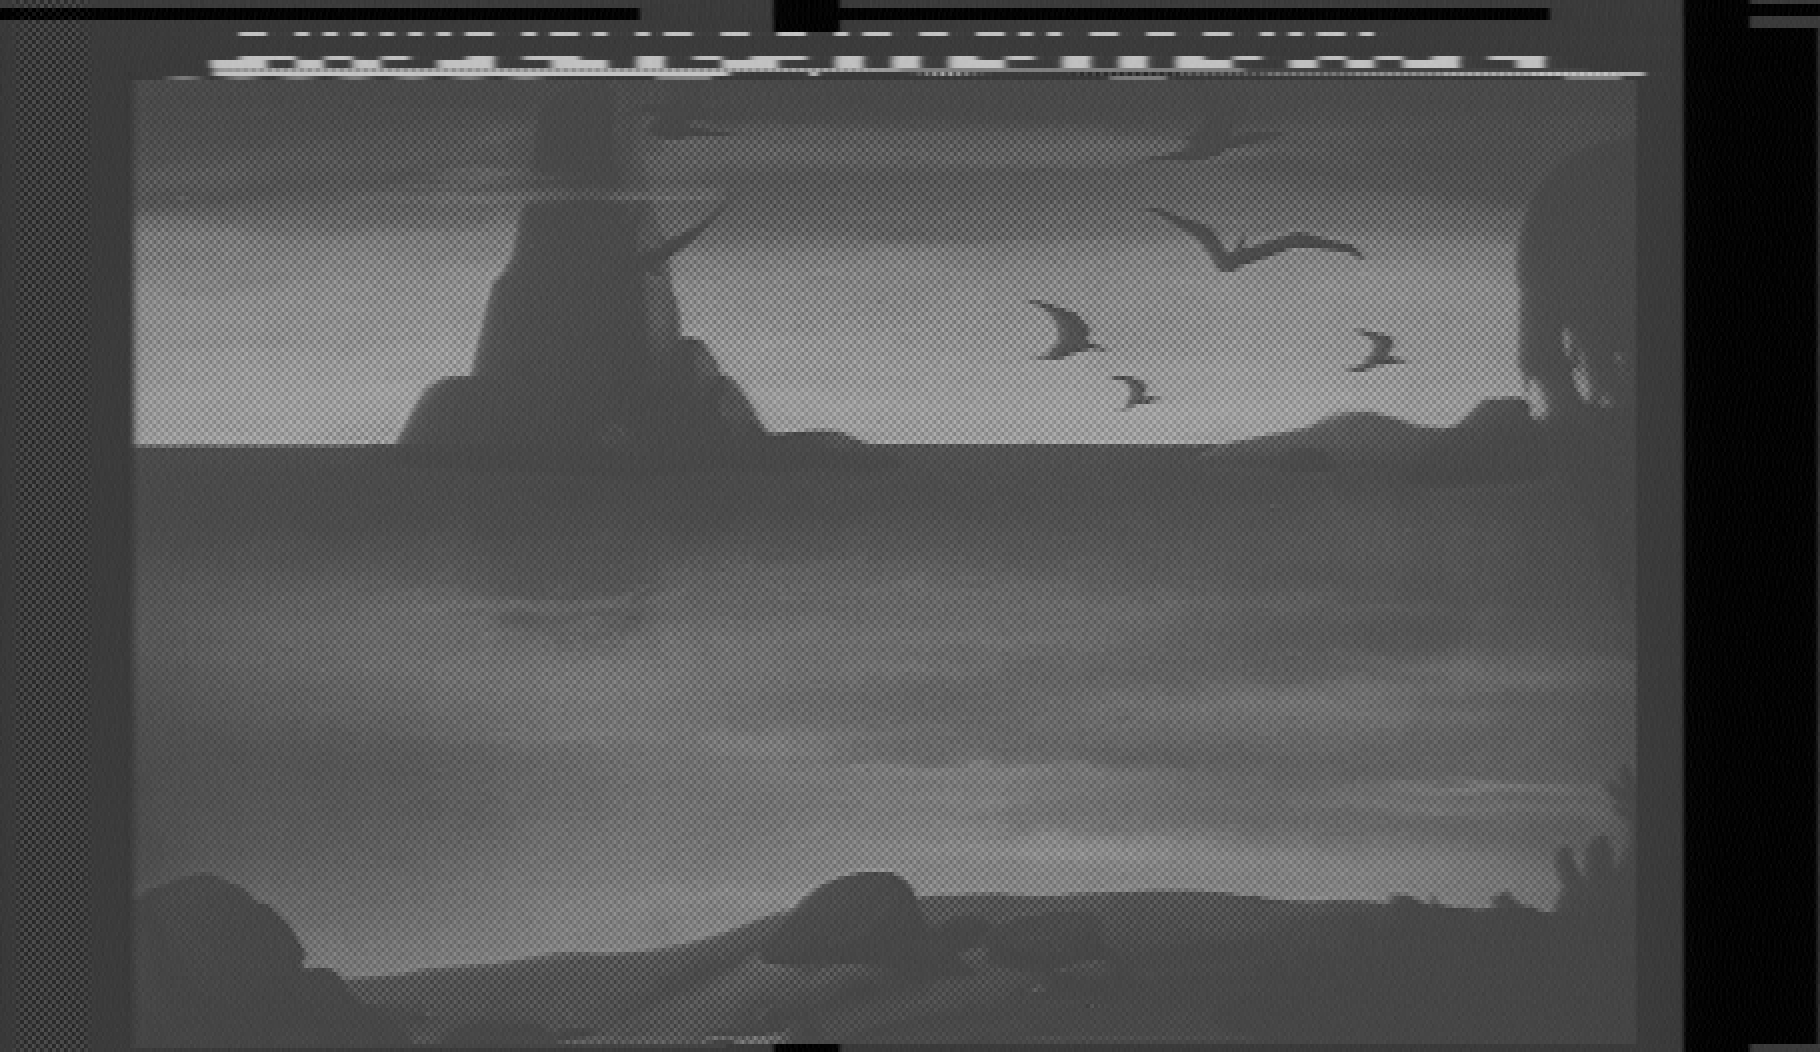

In [23]:
self = f1
ds1 = self.downscale(lineinfo=self.linelocs, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

(238420,)
uint8 (262, 910) (262, 910)


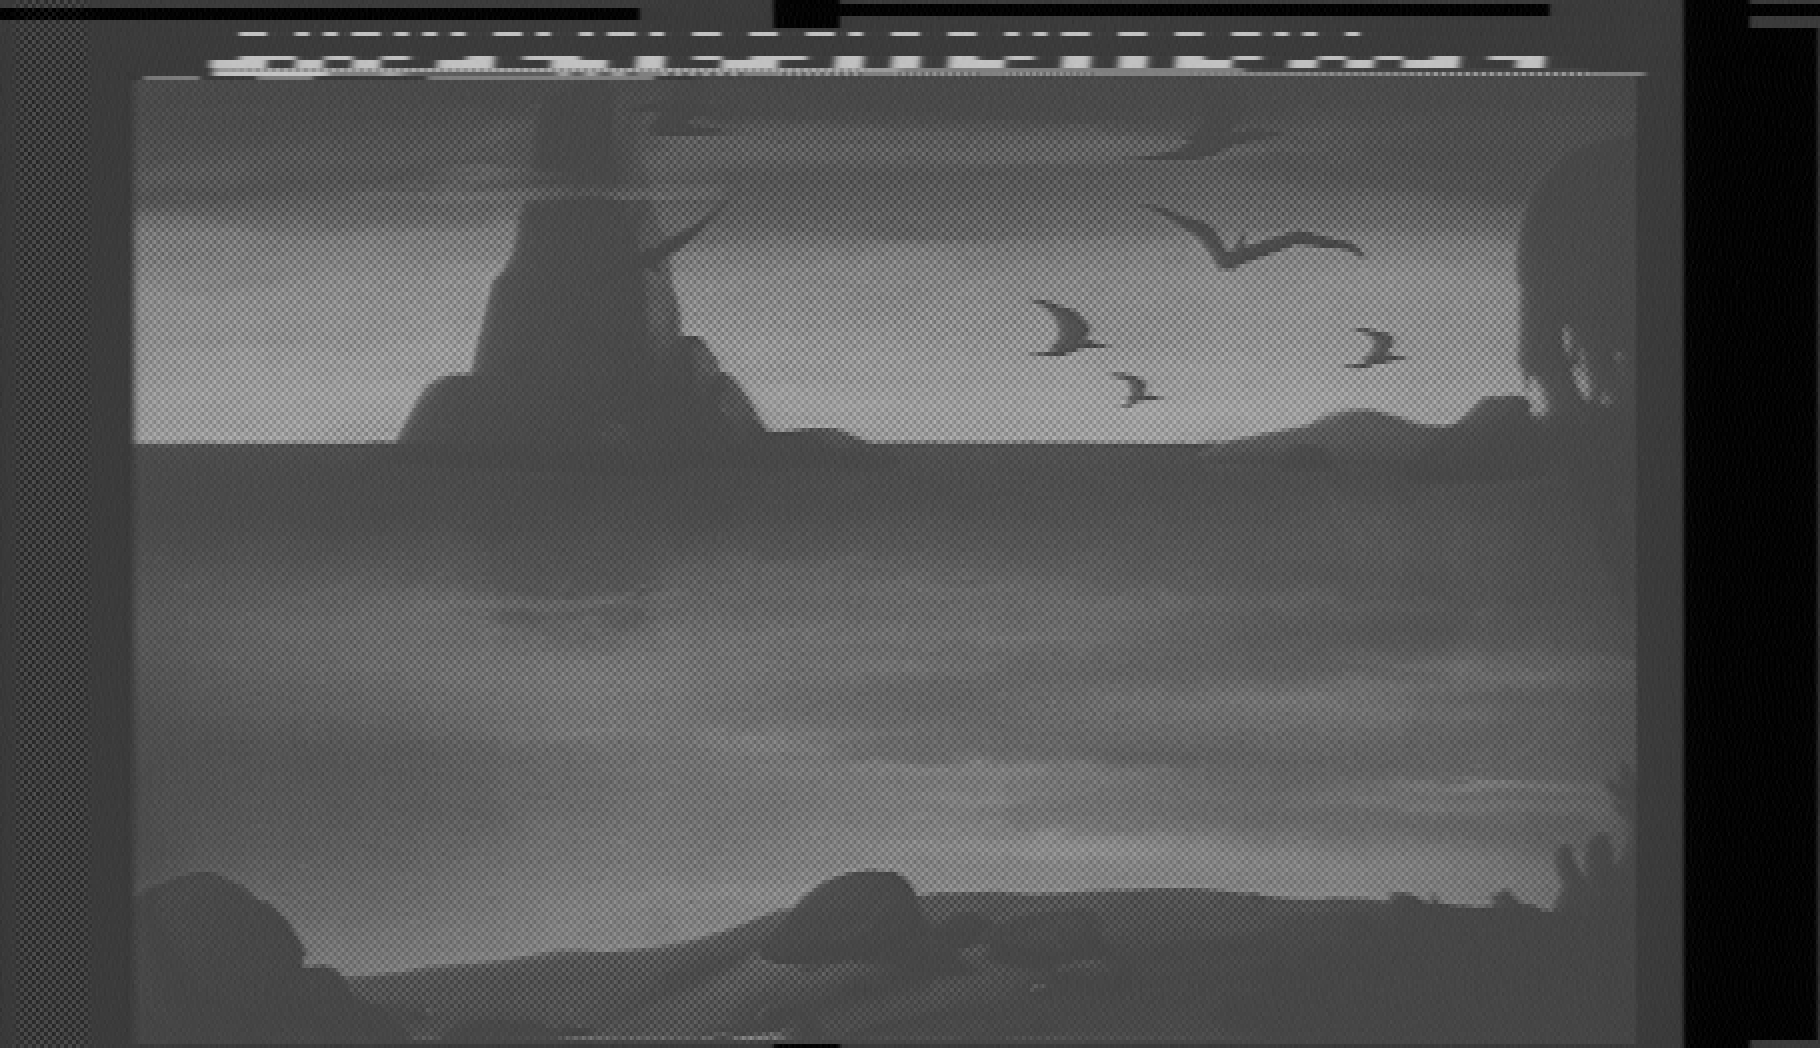

In [24]:
self = f2
ds1 = self.downscale(lineinfo=self.linelocs, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

lc 15 0x8dc01e
lc 16 0xf98202
lc 17 0xf98202
(239330,)
uint8 (263, 910) (263, 910)


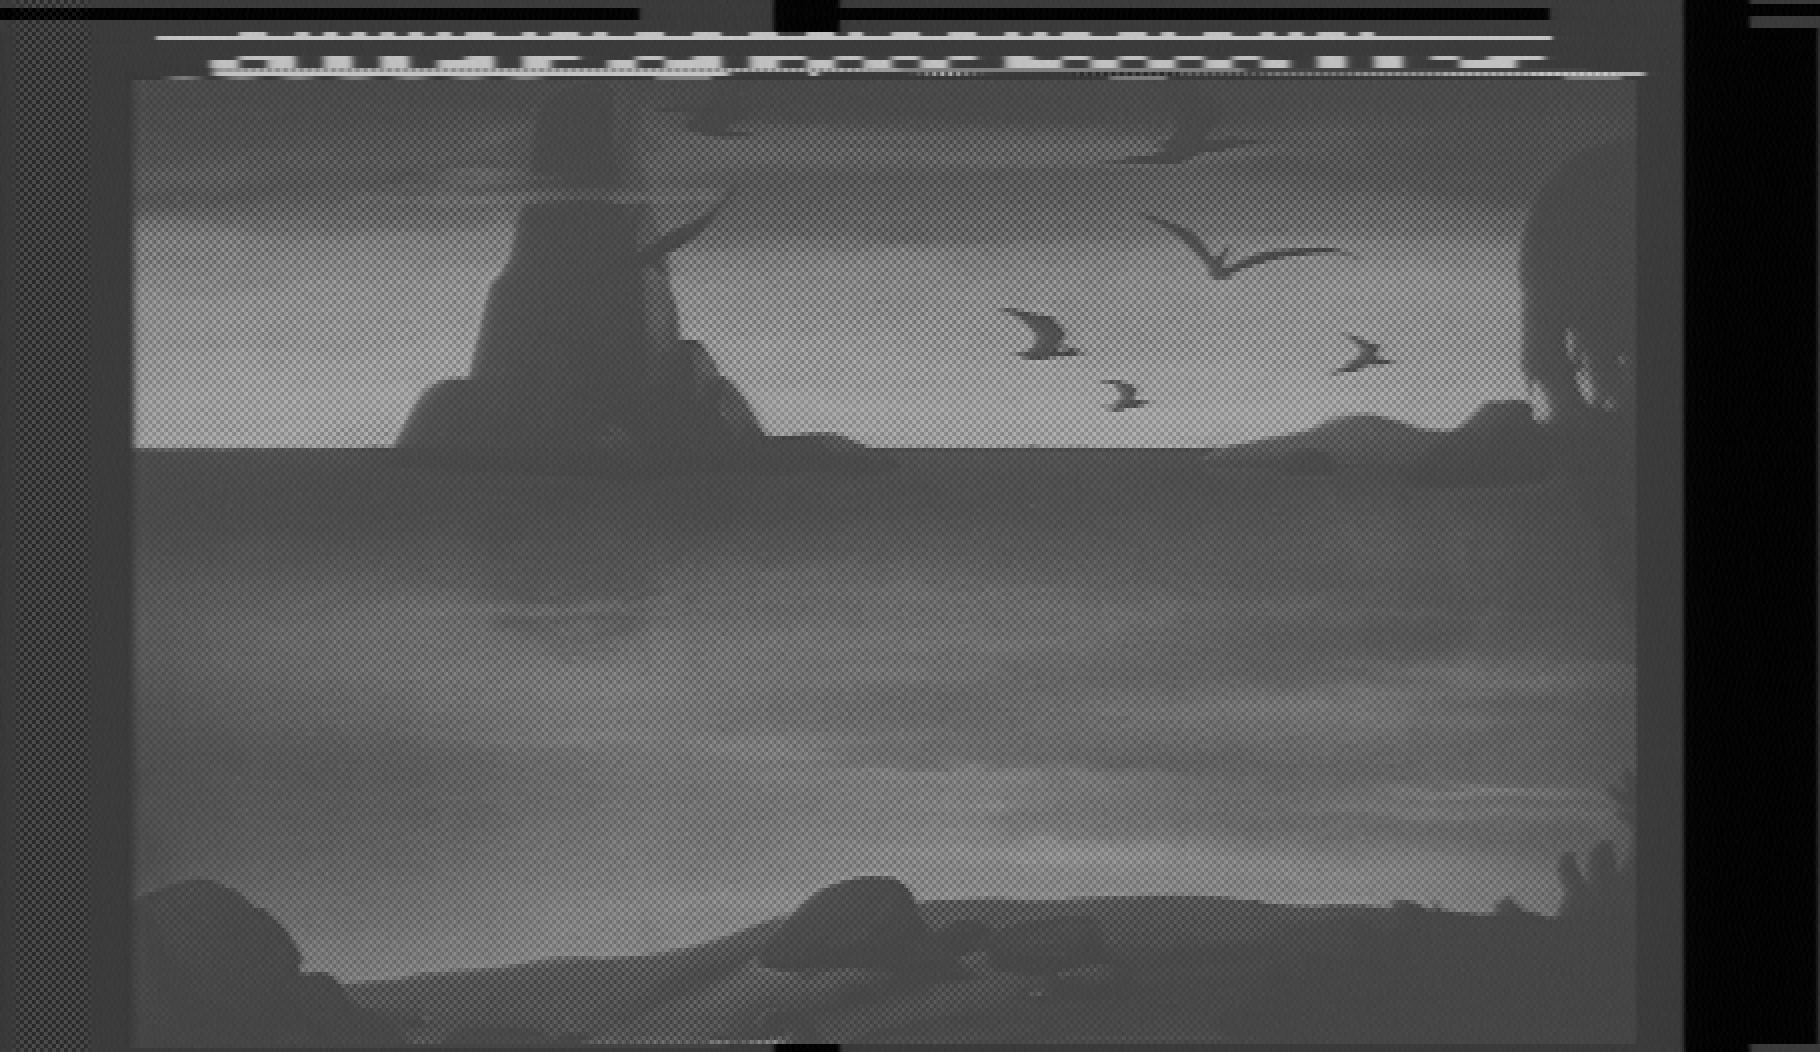

In [16]:
rf_ntsc = ldd.RFDecode(system='NTSC')
bytes_per_frame = int(rf_ntsc.freq_hz / rf_ntsc.SysParams['FPS'])
framer_ntsc = ldd.Framer(rf_ntsc)

infile_ntsc = open('/mnt3/dd/mit_side1_6x_2018-09-30_12-08-50.lds', 'rb')
#infile_ntsc = open('/mnt3/erica.lds', 'rb')
infile_ntsc = open('/home/cpage/vbitest/Fantasia_CAV_NTSC_side3_18200-18300_2018-11-06_09-21-07.lds', 'rb')
ldd.loader = load_packed_data_4_40

nextsample = 2245886145
#nextsample = 1051326849
nextsample = 1935574278
nextsample = 1954262190
nextsample = 0

rawdecode = rf_ntsc.demod(infile_ntsc, nextsample, framer_ntsc.readlen * 3, mtf_level=0)

fi = ldd.FieldNTSC(rf_ntsc, rawdecode, 800000)

fi.vsyncs

#ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
ds1 = self.downscale(lineinfo=self.linelocs, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

In [3]:
self.linelocs1[0:5]

NameError: name 'self' is not defined

In [33]:
self.linelocs[0:5]

array([21702.99114761, 24246.6666596 , 26790.43918839, 29334.55601501,
       31878.20831487])

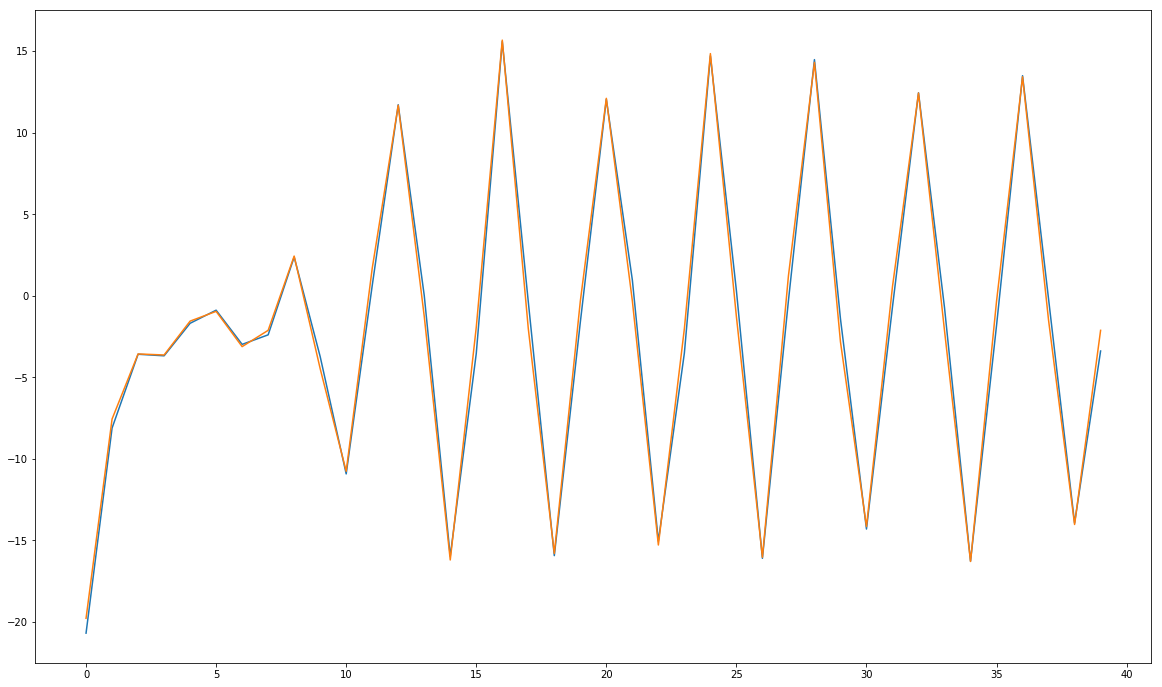

In [29]:
ds1 = self.downscale(lineinfo=self.linelocs3, wow=True)[0]
ds2 = self.downscale(lineinfo=self.linelocs4, wow=True)[0]

l = 17
m1 = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
m2 = (ds2 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
#plt.plot(r20[910*l:910*(l+1)])
#plt.plot(m40a[910*l:910*(l+1)])
#plt.plot(m40[910*l:910*(l+1)])
#plt.plot(m20[910*l:910*(l+1)])
plt.plot(m1[910*l:(910*(l+0))+40])
plt.plot(m2[910*l:(910*(l+0))+40])

In [160]:
.35*.9

0.315

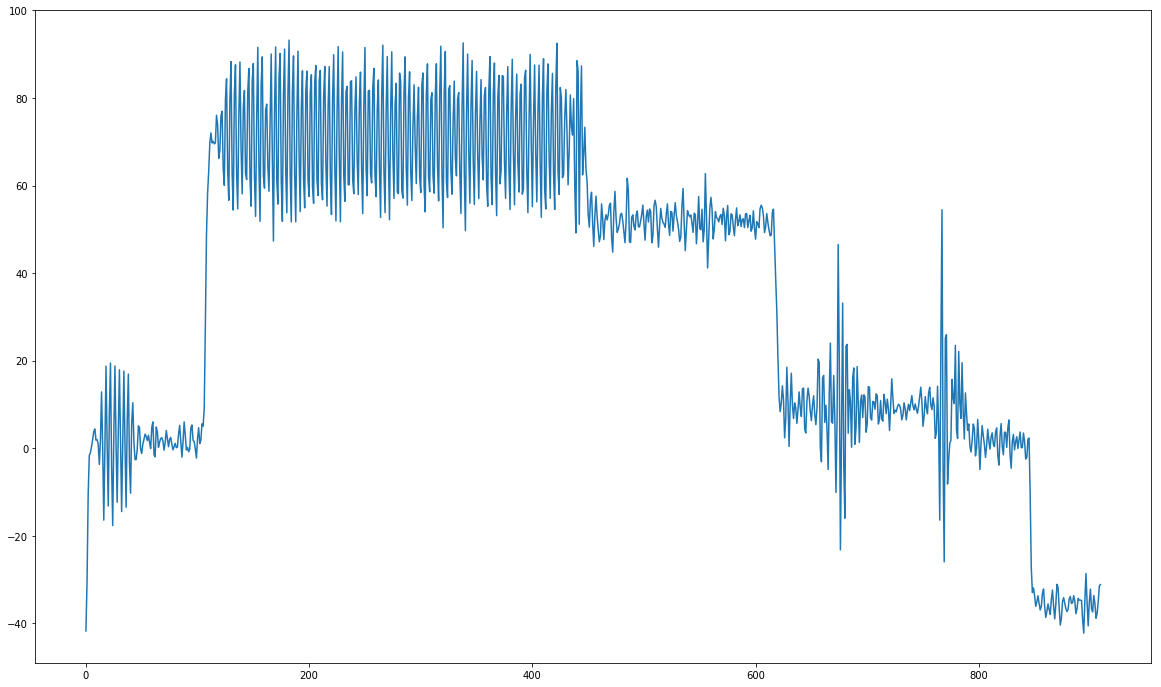

In [51]:
r1 = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
l = 17
plt.plot(r1[910*l:910*(l+1)])

In [38]:
fi.is_regular_hsync(50)

True

In [46]:
fi.vsyncs

array([[ 17,  10,   0],
       [287, 280,   1]])

In [39]:
def compute_linelocs(self):
    plist = self.peaklist

    # note: this is chopped on output, so allocating too many lines is OK
    linelocs = {}

    firstvisidx = None
    for i in range(0, self.vsyncs[1][1]): #self.vsyncs[1][1]):
        if i > self.vsyncs[0][0] and firstvisidx is None:
            #print(i, plist[i], plist[self.vsyncs[0][1]])
            firstvisidx = i

            break

    linelens = [self.inlinelen]
    prevlineidx = None
    for i in range(0, self.vsyncs[1][1]): #self.vsyncs[1][1]):
        med_linelen = np.median(linelens[-25:])

        if (self.is_regular_hsync(i)):

            if prevlineidx is not None:
                linegap = plist[i] - plist[prevlineidx]

                if inrange(linegap / self.inlinelen, .98, 1.02):
                    linelens.append(linegap)
                    linenum = prevlinenum + 1
                else:
                    linenum = prevlinenum + int(np.round((plist[i] - plist[prevlineidx]) / med_linelen))
            else:
                linenum = int(np.round((plist[i] - plist[self.vsyncs[0][1]]) / med_linelen))


            linelocs[linenum] = plist[i]
            print(linenum, plist[i])

            prevlineidx = i
            prevlinenum = linenum

            #print(linenum, plist[i], ((plist[i] - plist[self.vsyncs[0][1]]) / med_linelen), med_linelen)

    linelocs2 = copy.deepcopy(linelocs)

    for l in range(1, self.linecount + 5):
        if l not in linelocs:
            prev_valid = None
            next_valid = None

            for i in range(l, -10, -1):
                if i in linelocs:
                    prev_valid = i
                    break
            for i in range(l, self.linecount + 1):
                if i in linelocs:
                    next_valid = i
                    break

            print(l, prev_valid, next_valid)

            if prev_valid is None:
                avglen = self.inlinelen
                linelocs2[l] = linelocs[next_valid] - (avglen * (next_valid - l))
            elif next_valid is not None:
                avglen = (linelocs[next_valid] - linelocs[prev_valid]) / (next_valid - prev_valid)
                #print(prev_valid, next_valid, avglen)
                linelocs2[l] = linelocs[prev_valid] + (avglen * (l - prev_valid))
            else:
                avglen = linelocs[prev_valid] - linelocs2[prev_valid - 1]
                linelocs2[l] = linelocs[prev_valid] + (avglen * (l - prev_valid))

            #print(l, linelocs2[l] - linelocs2[l - 1], avglen, linelocs2[l], linelocs[10], prev_valid, next_valid)

    rv_ll = [linelocs2[l] for l in range(1, self.linecount + 5)]
    rv_err = [l not in linelocs for l in range(1, self.linecount + 5)]

    for i in range(0, 10):
        rv_err[i] = False

    return rv_ll, rv_err

compute_linelocs(fi)

-370 53588
-369 56141
-368 58693
-367 61245
-365 66349
-364 68900
-363 71451
-362 74003
-361 76554
-360 79106
-359 81657
-358 84208
-357 86759
-356 89310
-355 91861
-353 96963
-352 99513
-351 102064
-350 104614
-349 107165
-348 109715
-347 112265
-345 117365
-343 122465
-342 125015
-341 127564
-340 130114
-339 132663
-338 135213
-337 137763
-336 140312
-335 142861
-334 145411
-333 147959
-332 150509
-331 153058
-330 155606
-329 158155
-328 160704
-327 163254
-326 165802
-325 168350
-324 170899
-323 173447
-322 175996
-321 178544
-320 181093
-319 183641
-318 186189
-317 188737
-316 191285
-315 193833
-314 196380
-313 198928
-312 201476
-311 204024
-310 206572
-309 209119
-308 211666
-307 214213
-306 216761
-305 219308
-304 221855
-303 224402
-302 226949
-301 229496
-300 232043
-299 234589
-298 237136
-297 239683
-296 242229
-295 244776
-294 247322
-293 249868
-292 252414
-290 257507
-289 260052
-288 262599
-287 265144
-286 267690
-285 270236
-284 272781
-283 275327
-282 277872
-281 2804

KeyError: None

(354120,)
uint8 (312, 1135) (312, 1135)


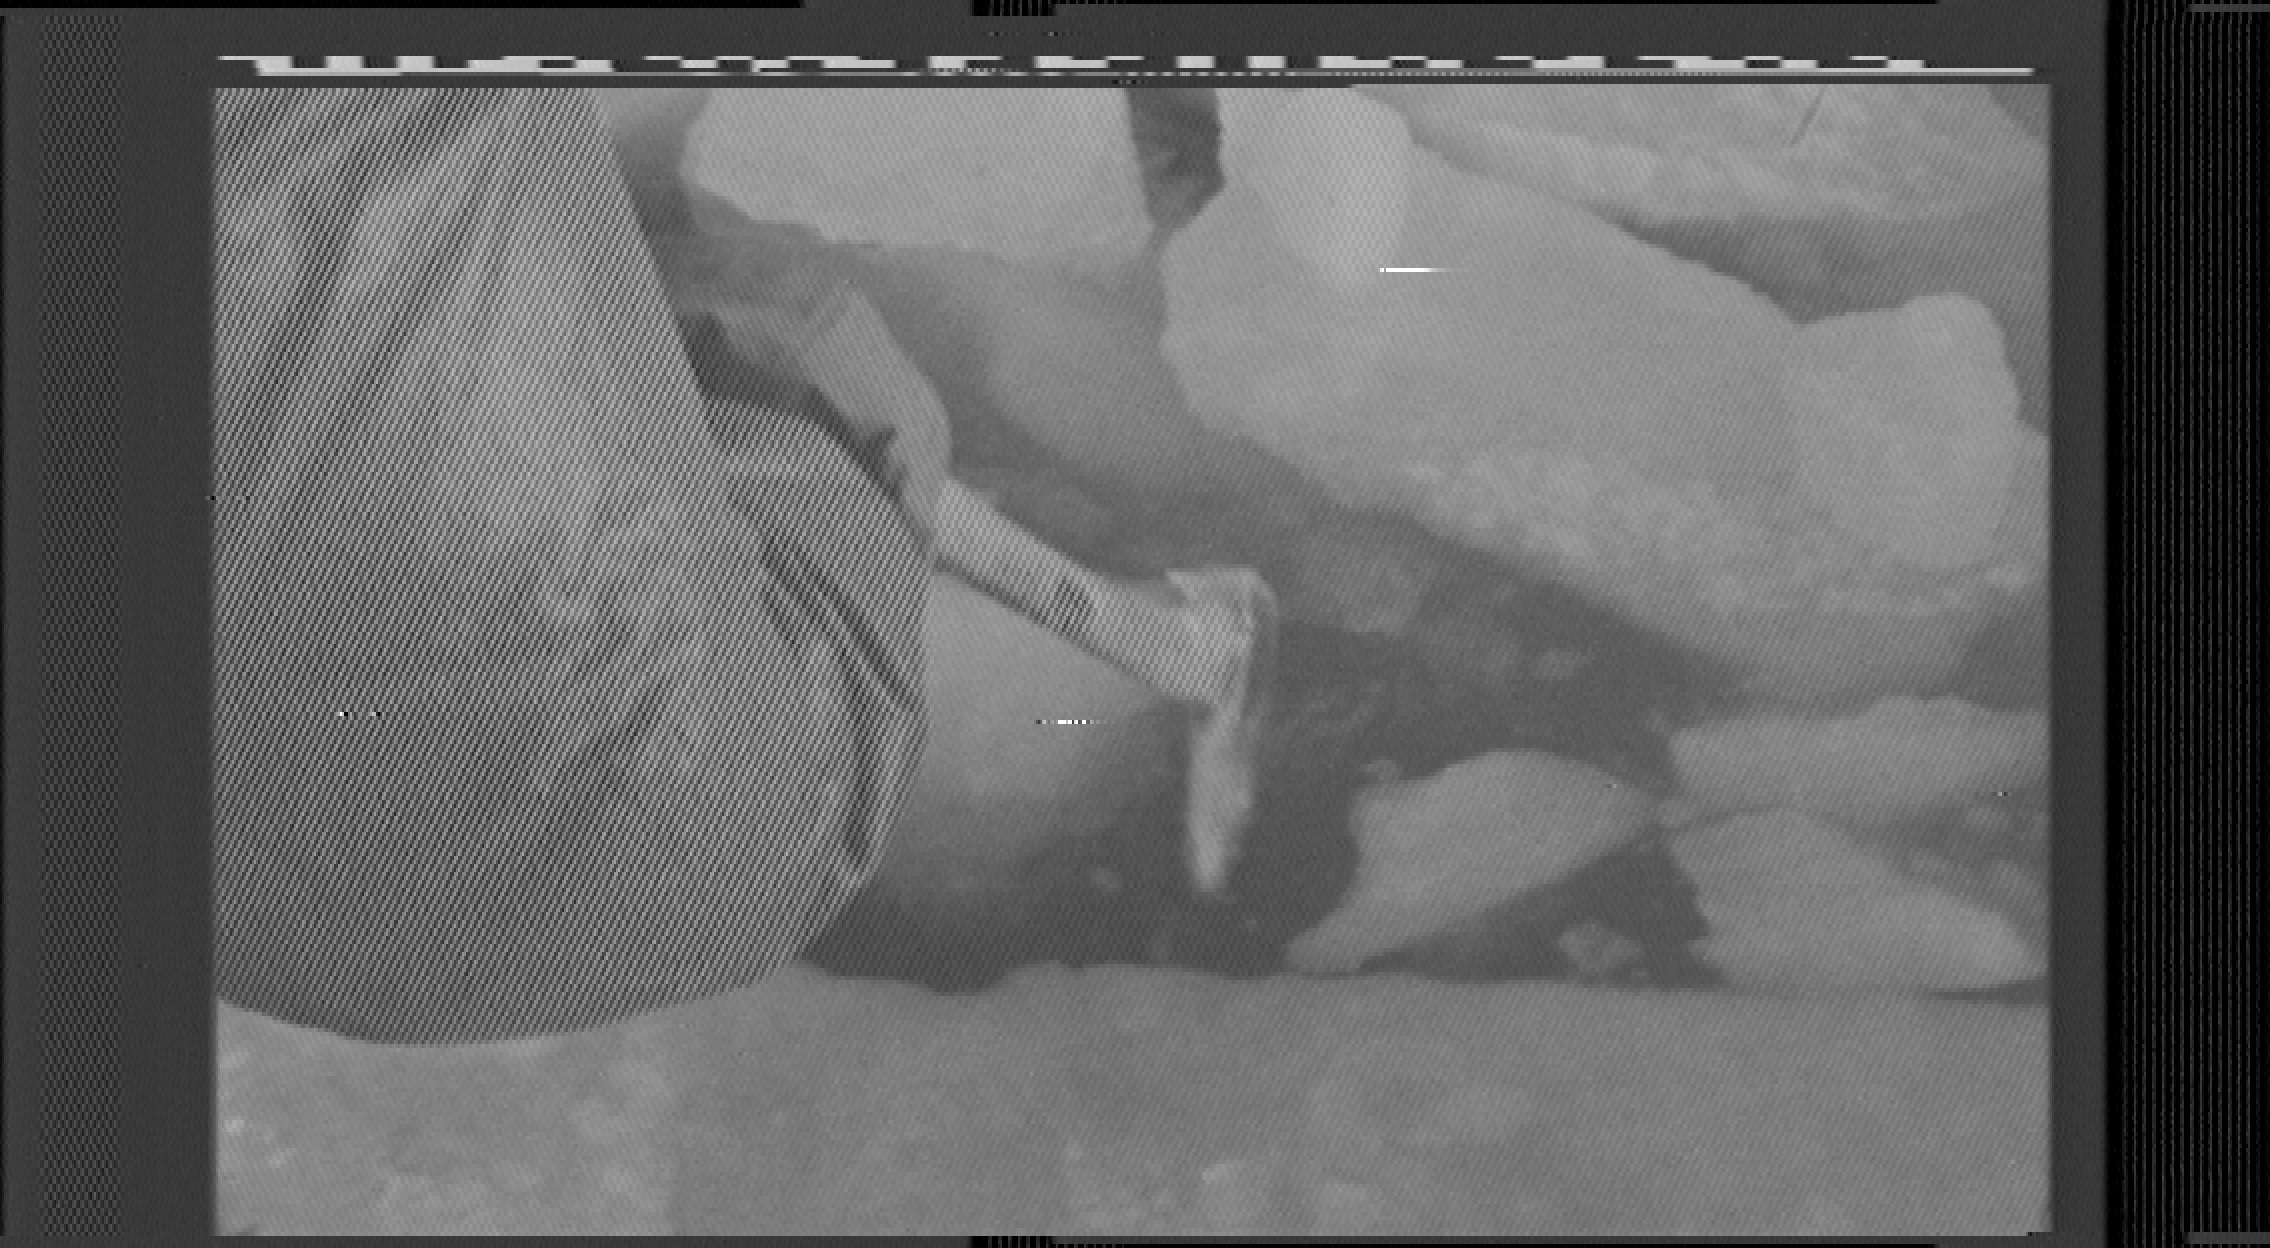

In [251]:
rf_pal = ldd.RFDecode(system='PAL')
bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])
framer_pal = ldd.Framer(rf_pal)

infile_pal = open('/mnt3/dd/DVL909E_AIV_NORTH_POLE_CAV_FULL.lds', 'rb')
ldd.loader = load_packed_data_4_40

nextsample = 12603451155
nextsample = (bytes_per_frame * 40000)

rawdecode = rf_pal.demod(infile_pal, nextsample, framer_pal.readlen * 2, mtf_level=1)

fi = ldd.FieldPAL(rf_pal, rawdecode, 0)

#fi.vsyncs
#ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
ds1 = self.downscale(lineinfo=self.linelocs2, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

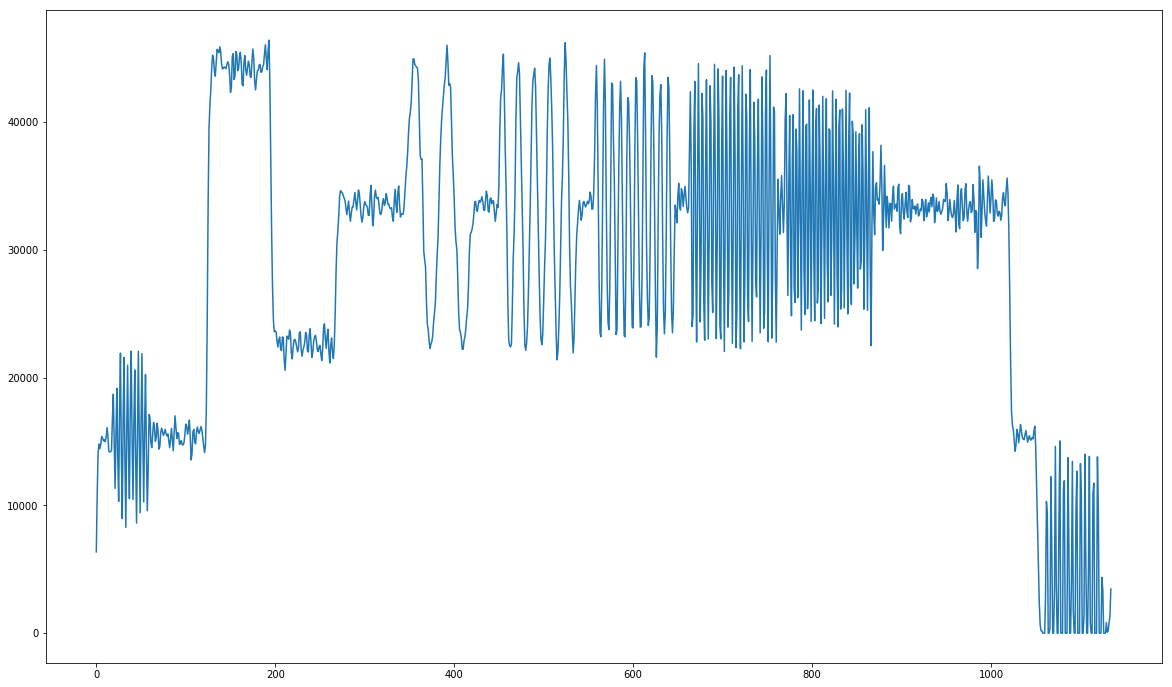

In [186]:
l = 18
plt.plot(lines16[1135*l:1135*(l+1)])

(239330,)
uint8 (263, 910) (263, 910)


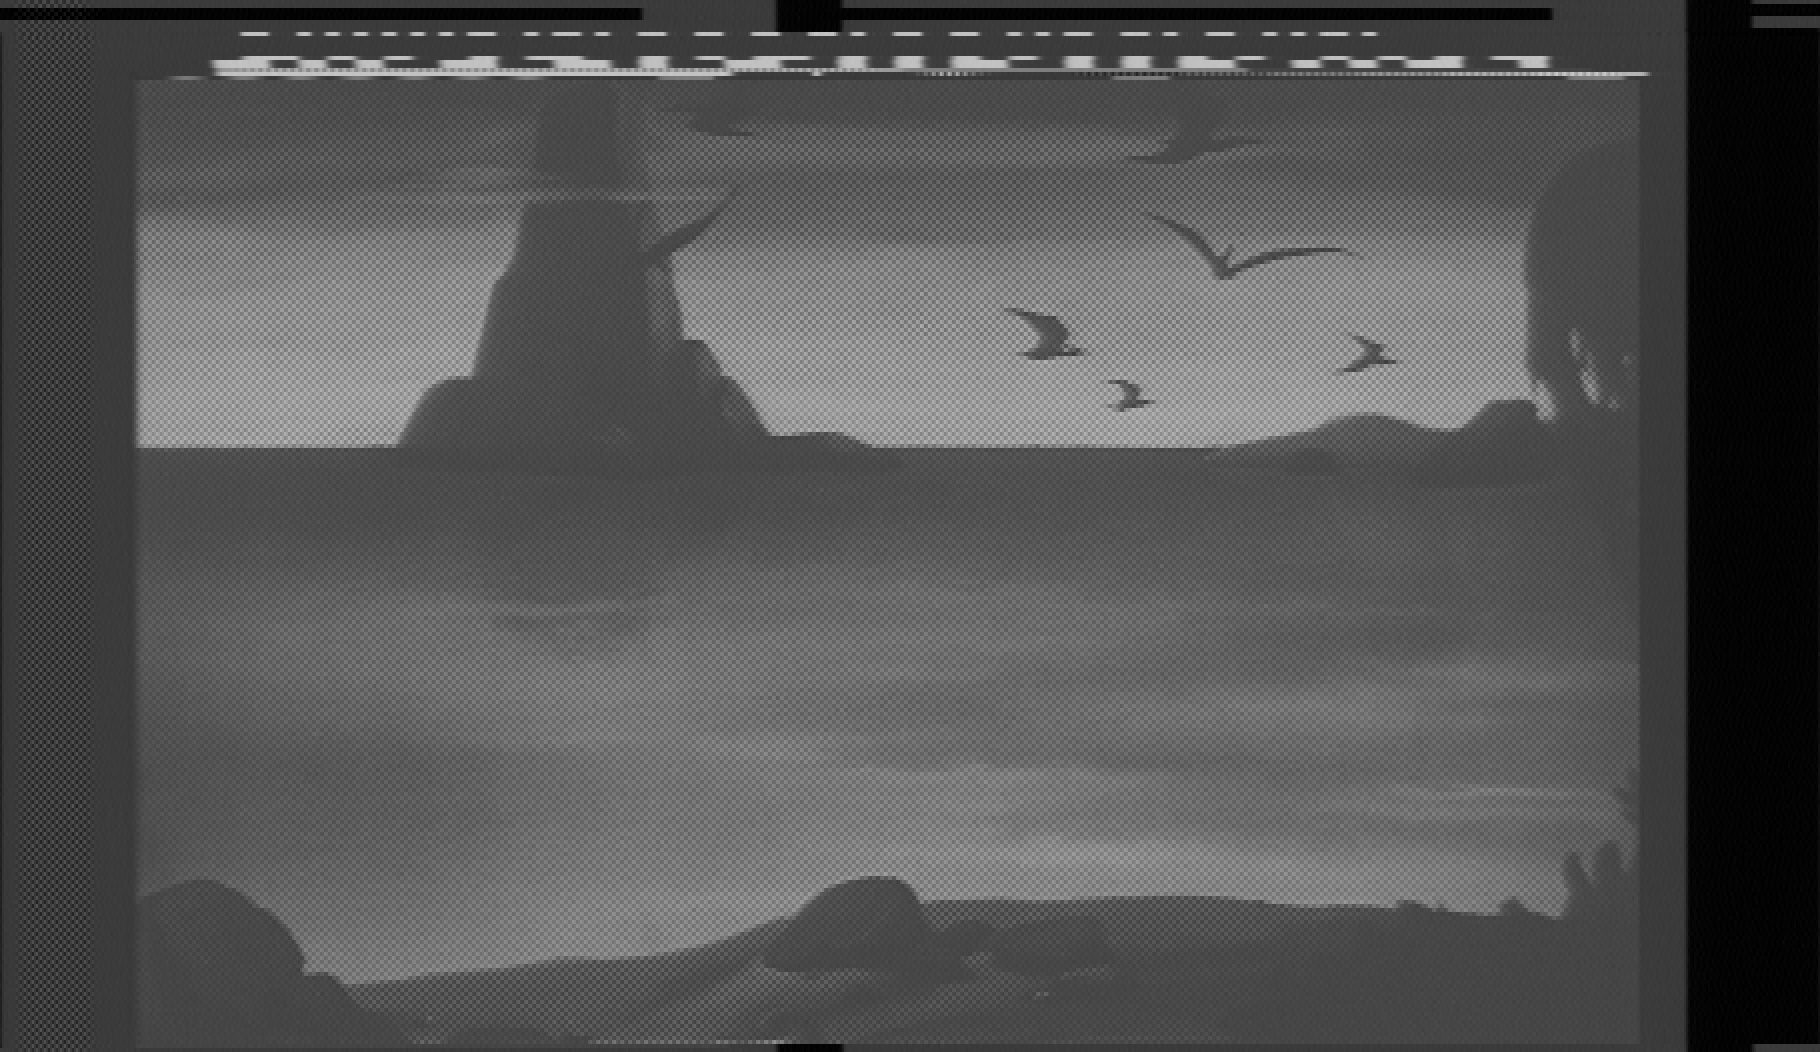

In [34]:
rf_pal = ldd.RFDecode(system='PAL')
bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])
framer_pal = ldd.Framer(rf_pal)

infile_pal = open('/home/cpage/vbitest/Roger Rabbit Bonus_CAV_PAL_side1_22700-22800_2018-11-06_10-08-05.lds', 'rb')
ldd.loader = load_packed_data_4_40

nextsample = 12603451155
nextsample = (bytes_per_frame * 1890)
nextsample = 0

rawdecode = rf_pal.demod(infile_pal, nextsample, framer_pal.readlen * 3)

fi1 = ldd.FieldPAL(rf_pal, rawdecode, 0)
fi2 = ldd.FieldPAL(rf_pal, rawdecode, fi1.nextfieldoffset)

#fi.vsyncs
#ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
ds1 = self.downscale(lineinfo=self.linelocs2, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

In [42]:
fi1.istop, fi2.istop

(1, 0)

In [35]:
ds1 = fi1.downscale(lineoffset=0)
ds2 = fi2.downscale(lineoffset=0)

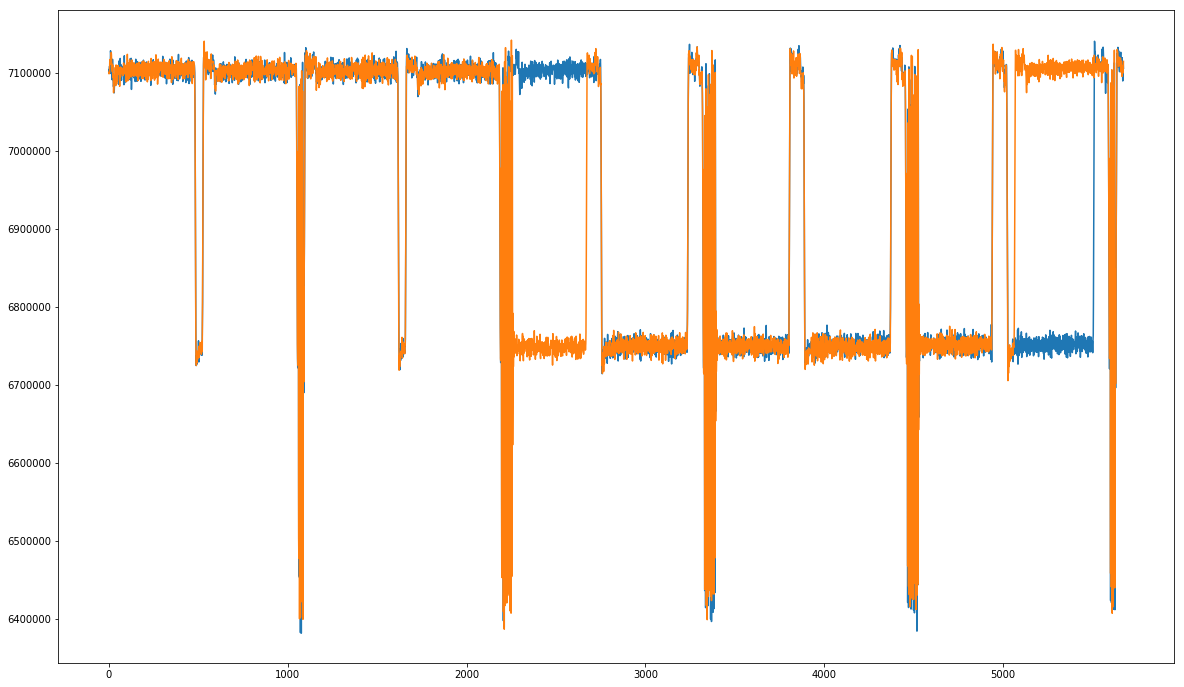

In [44]:
l1 = 0
l2 = 5
plt.plot(ds1[0][1135*l1:1135*l2])
plt.plot(ds2[0][1135*l1:1135*l2])

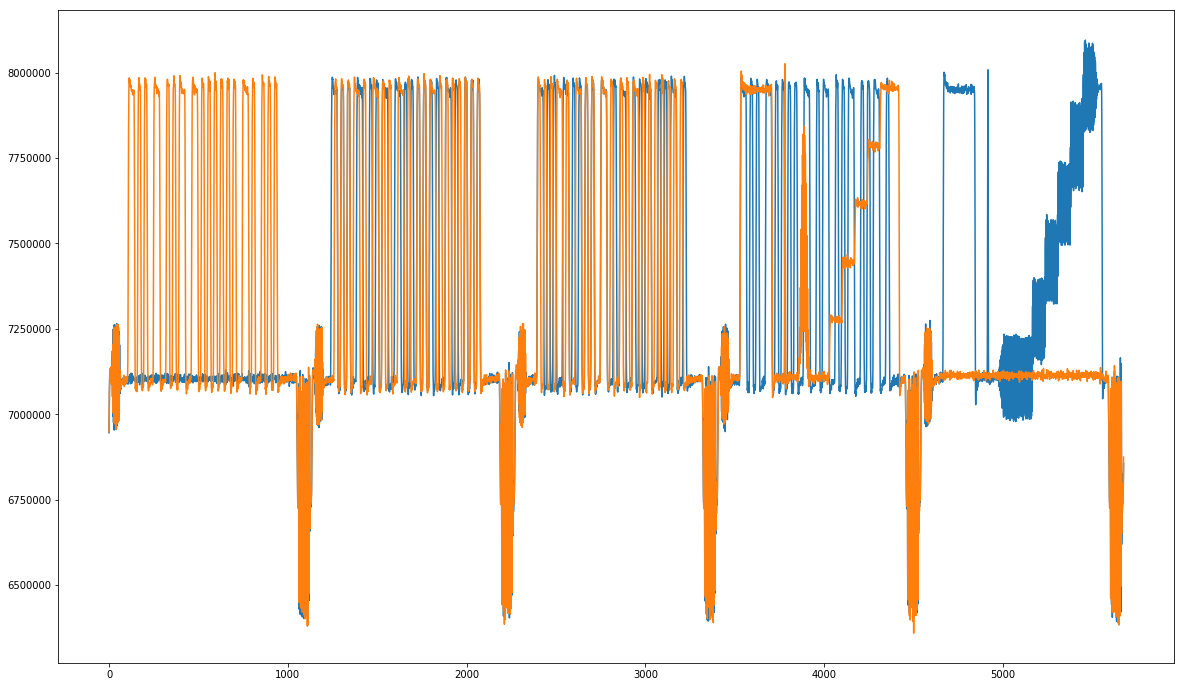

In [40]:
l1 = 17
l2 = 22
plt.plot(ds1[0][1135*l1:1135*l2])
plt.plot(ds2[0][1135*l1:1135*l2])

In [3]:
fi.nextfieldoffset


1082166

(355255,)
uint8 (313, 1135) (313, 1135)


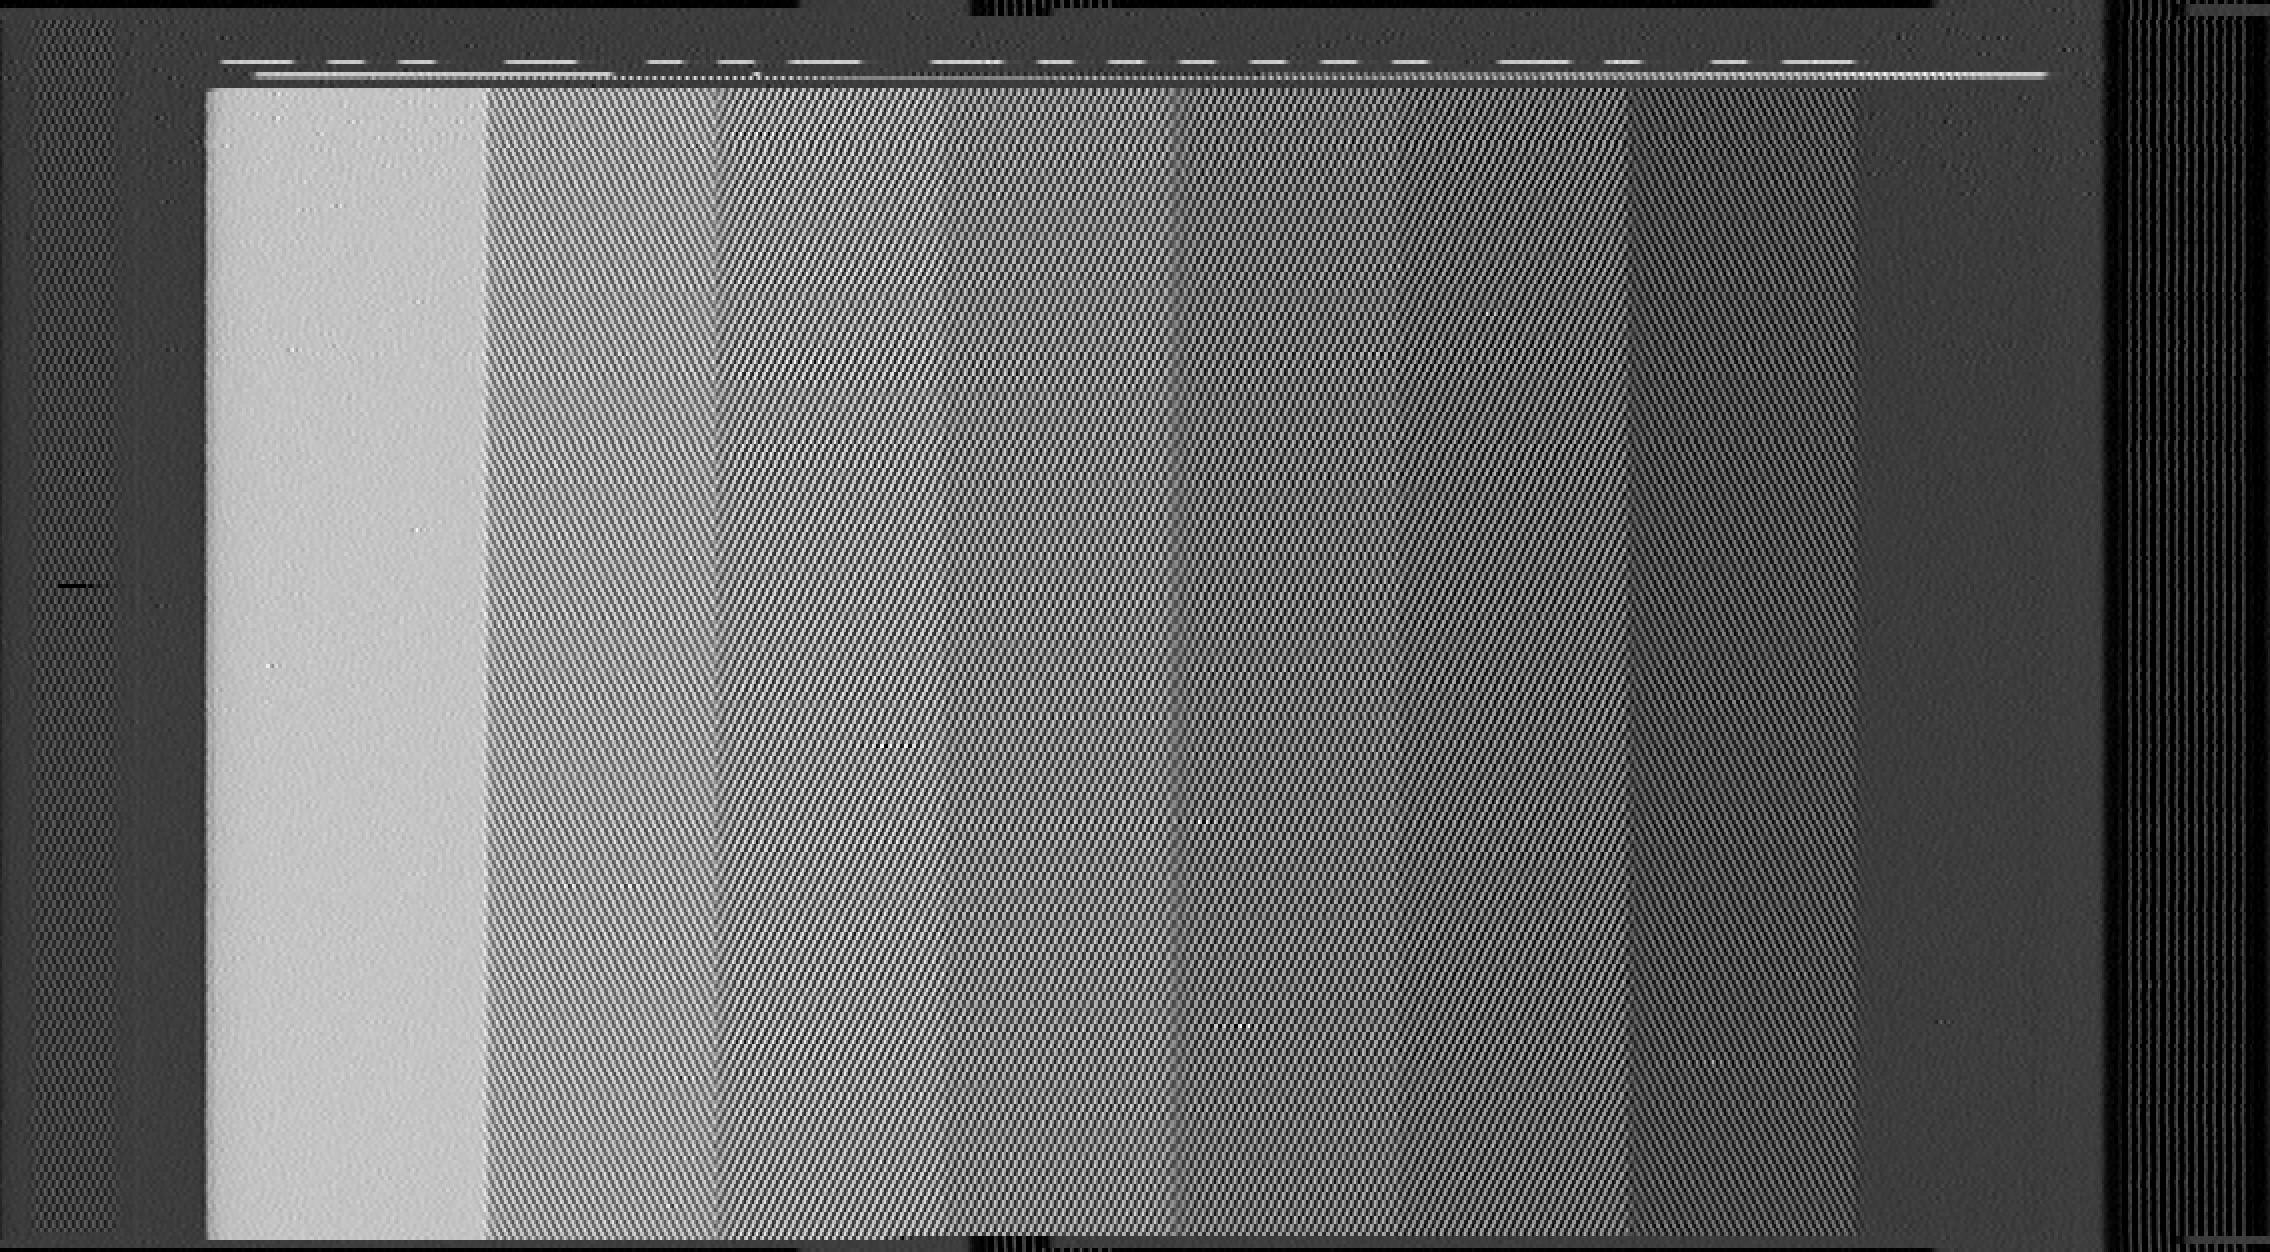

In [106]:
#ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
ds1 = self.downscale(lineinfo=self.linelocs2, wow=False)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

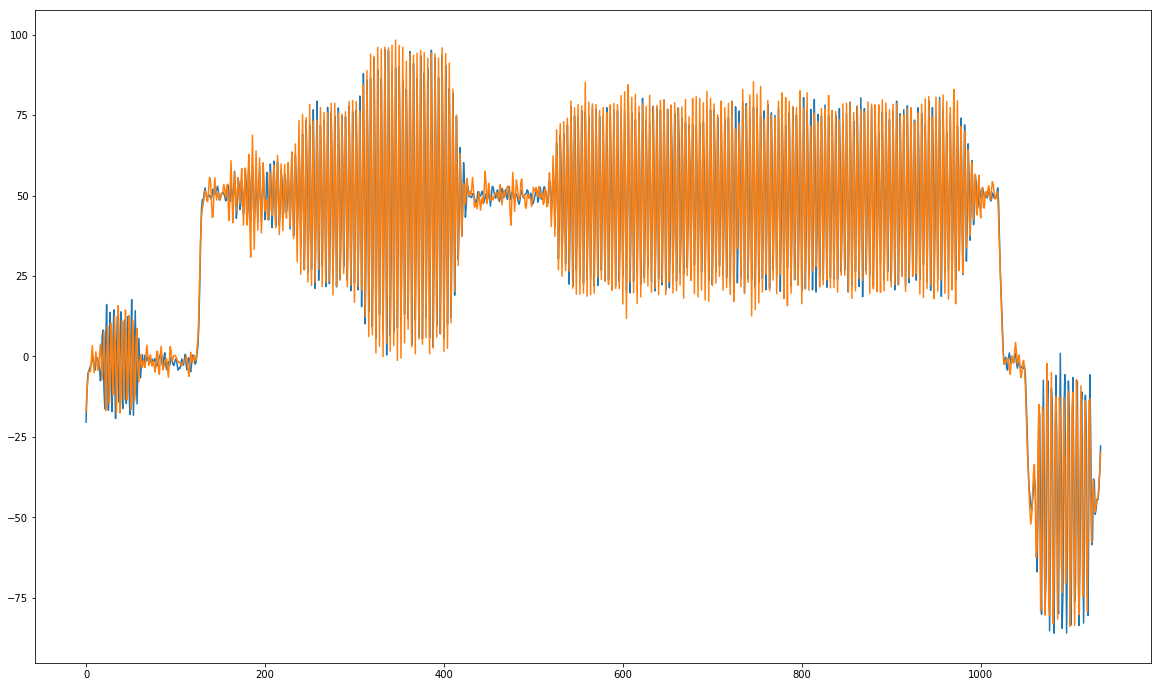

In [125]:
rf_pal = ldd.RFDecode(system='PAL')

rf_pal.DecoderParams = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 200000,
    'audio_notchorder': 2,

    'video_deemp': (100*.4, 400*.4),

    # XXX: guessing here!
    'video_bpf': (2500000, 14500000),
    'video_bpf_order': 3,

    'video_lpf_freq': 5200000,
    'video_lpf_order': 9,
}

rf_pal.computefilters()

bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])
framer_pal = ldd.Framer(rf_pal)

infile_pal = open('/mnt3/dd/Domesday National_CAV_PAL_side1_Disc set 2_2018-10-02_18-14-36.lds', 'rb')
ldd.loader = load_packed_data_4_40

nextsample = 12603451155
nextsample = (bytes_per_frame * 11890)
nextsample = (bytes_per_frame * 5000)

rawdecode = rf_pal.demod(infile_pal, nextsample, framer_pal.readlen * 2, mtf_level=0.6)

fi = ldd.FieldPAL(rf_pal, rawdecode, 0)

#fi.vsyncs

#ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
ds1 = self.downscale(lineinfo=self.linelocs2, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
#draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

r5a = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
l = 19
#plt.plot(r1[1135*l:1135*(l+1)])
plt.plot(r3[1135*l:1135*(l+1)])
plt.plot(r2[1135*l:1135*(l+1)])


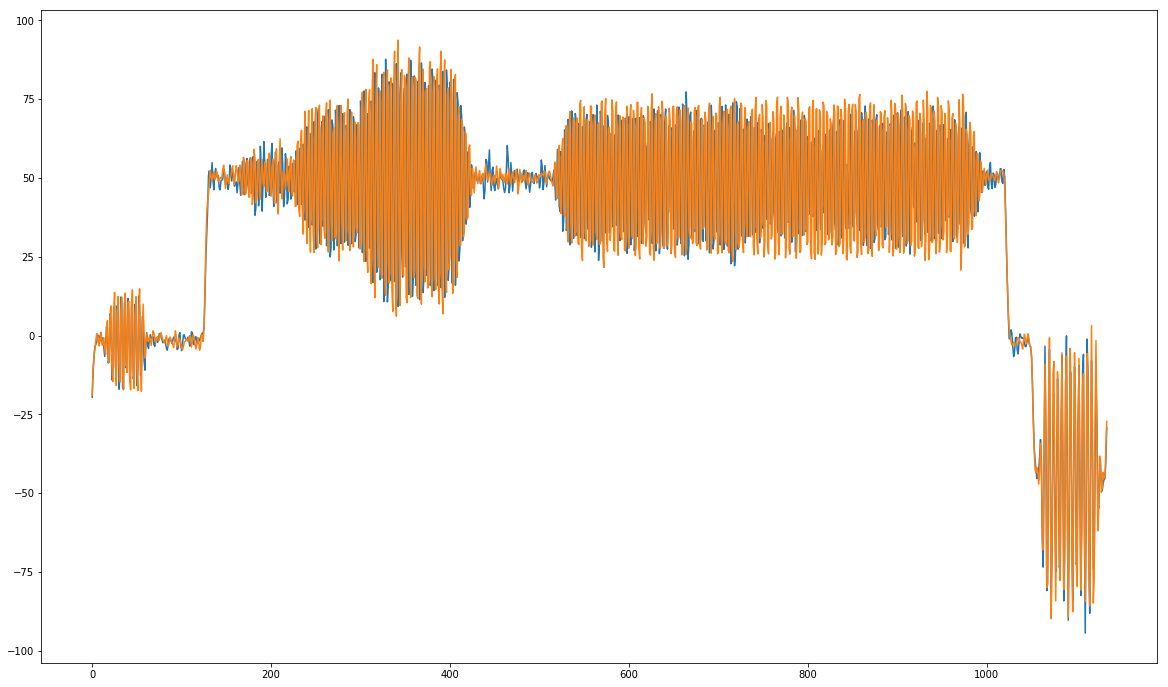

In [126]:
plt.plot(r5a[1135*l:1135*(l+1)])
plt.plot(r10[1135*l:1135*(l+1)])


(355255,)
uint8 (313, 1135) (313, 1135)


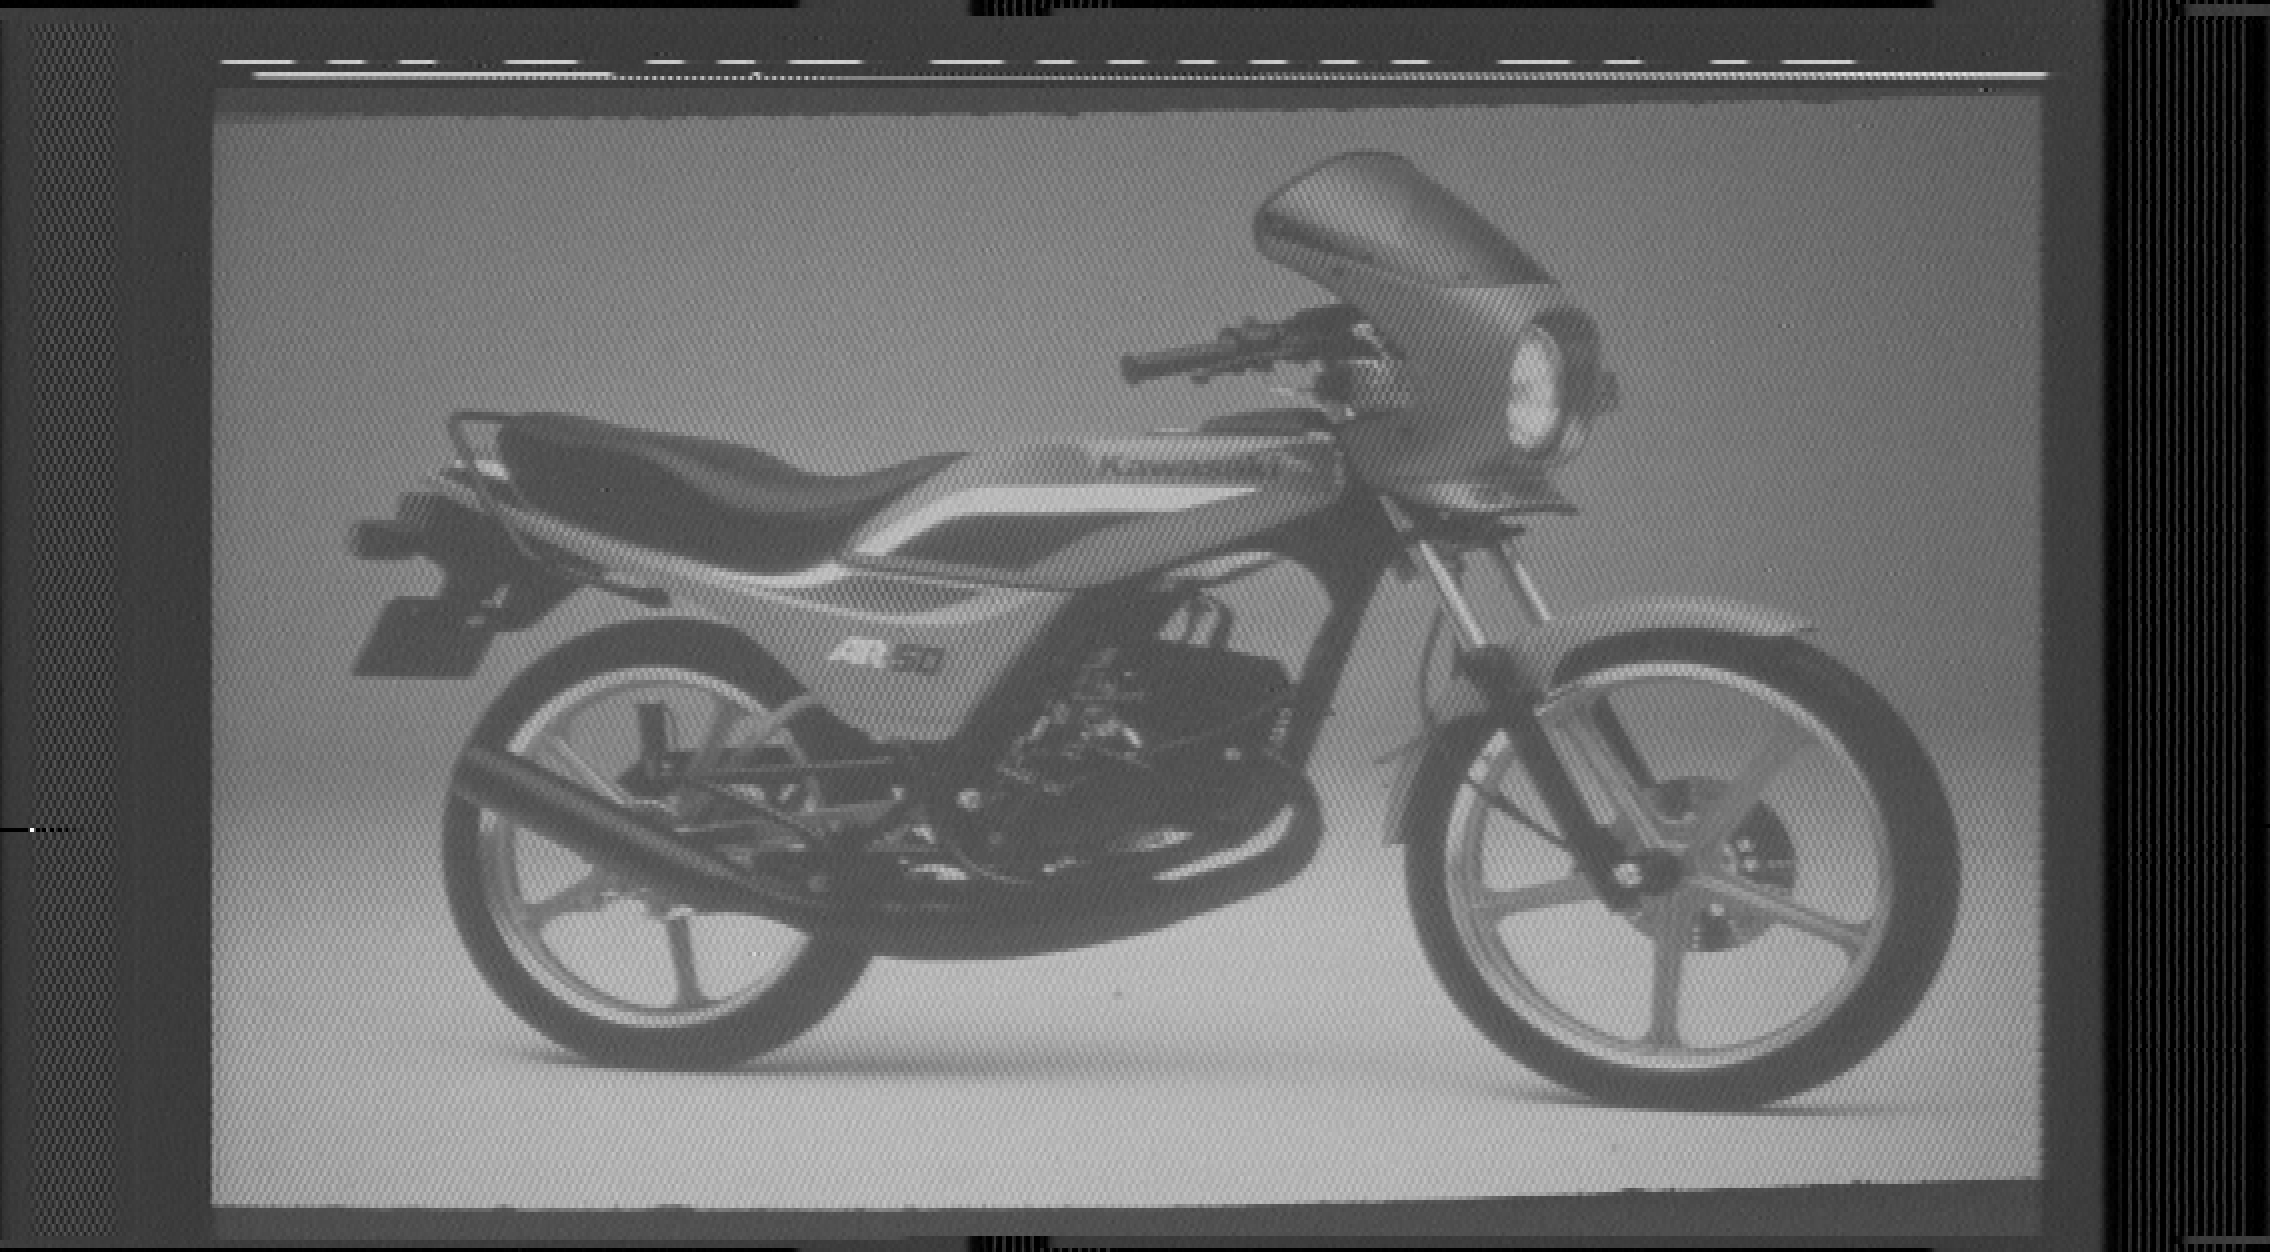

In [43]:
def refine_linelocs_hsync(self):
    # Adjust line locations to end of HSYNC.
    # This causes issues for lines 1-9, where only the beginning is reliable :P

    err = [False] * len(self.linelocs1)

    linelocs2 = self.linelocs1.copy()
    for i in range(len(self.linelocs1)):
        # First adjust the lineloc before the beginning of hsync - 
        # lines 1-9 are half-lines which need a smaller offset
        if i < 9:
            linelocs2[i] -= 200 # search for *beginning* of hsync

        ll1 = linelocs2[i]
        zc = calczc(self.data[0]['demod_05'], linelocs2[i], self.rf.iretohz(-20), reverse=False, _count=400)

        if zc is not None:
            linelocs2[i] = zc 

            if i >= 10:
                # sanity check 0.5mhz filtered HSYNC and colo[u]r burst area

                # it's possible that the zero crossing is thrown by bad data, so look at original peak
                origdata_hsync1 = self.data[0]['demod_05'][int(ll1-(self.rf.freq*2)):int(ll1+(self.rf.freq*2))]
                origdata_hsync = self.data[0]['demod_05'][int(zc-(self.rf.freq*1)):int(zc+(self.rf.freq*3))]
                origdata_burst = self.data[0]['demod_05'][int(zc+(self.rf.freq*1)):int(zc+(self.rf.freq*3))]

                if ((np.min(origdata_hsync) < self.rf.iretohz(-60) or np.max(origdata_hsync) > self.rf.iretohz(20)) or 
                       (np.min(origdata_hsync1) < self.rf.iretohz(-60) or np.max(origdata_hsync1) > self.rf.iretohz(100)) or 
                       (np.min(origdata_burst) < self.rf.iretohz(-10) or np.max(origdata_burst) > self.rf.iretohz(10))):
                    err[i] = True
                else:
                    # on some captures with high speed variation wow effects can mess up TBC.
                    # determine the low and high values and recompute zc along the middle

                    low = np.mean(origdata_hsync[0:20])
                    high = np.mean(origdata_hsync[100:120])

                    zc2 = calczc(origdata_hsync, 0, (low + high) / 2, reverse=False, _count=len(origdata_hsync))
                    zc2 += (int(zc)-(self.rf.freq*1))

                    if np.abs(zc2 - zc) < (self.rf.freq / 4):
                        linelocs2[i] = zc2 
                    else:
                        err[i] = True
        else:
            err[i] = True

        if i < 10:
            linelocs2[i] += self.usectoinpx(4.72)

        if i > 10 and err[i]:
            gap = linelocs2[i - 1] - linelocs2[i - 2]
            linelocs2[i] = linelocs2[i - 1] + gap

    # XXX: HACK!
    # On both PAL and NTSC this gets it wrong for VSYNC areas.  They need to be *reasonably* 
    # accurate for analog audio, but are never seen in the picture.
    for i in range(9, -1, -1):
        gap = linelocs2[i + 1] - linelocs2[i]
        if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
            gap = self.rf.linelen

        linelocs2[i] = linelocs2[i + 1] - gap

    # XXX2: more hack!  This one covers a bit at the end of a PAL field
    for i in range(len(linelocs2) - 10, len(linelocs2)):
        gap = linelocs2[i] - linelocs2[i - 1]
        if not inrange(gap, self.rf.linelen - (self.rf.freq * .2), self.rf.linelen + (self.rf.freq * .2)):
            gap = self.rf.linelen

        linelocs2[i] = linelocs2[i - 1] + gap

    return linelocs2, err   

ll, err = refine_linelocs_hsync(fi)

self = fi
ds1 = self.downscale(lineinfo=ll, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)


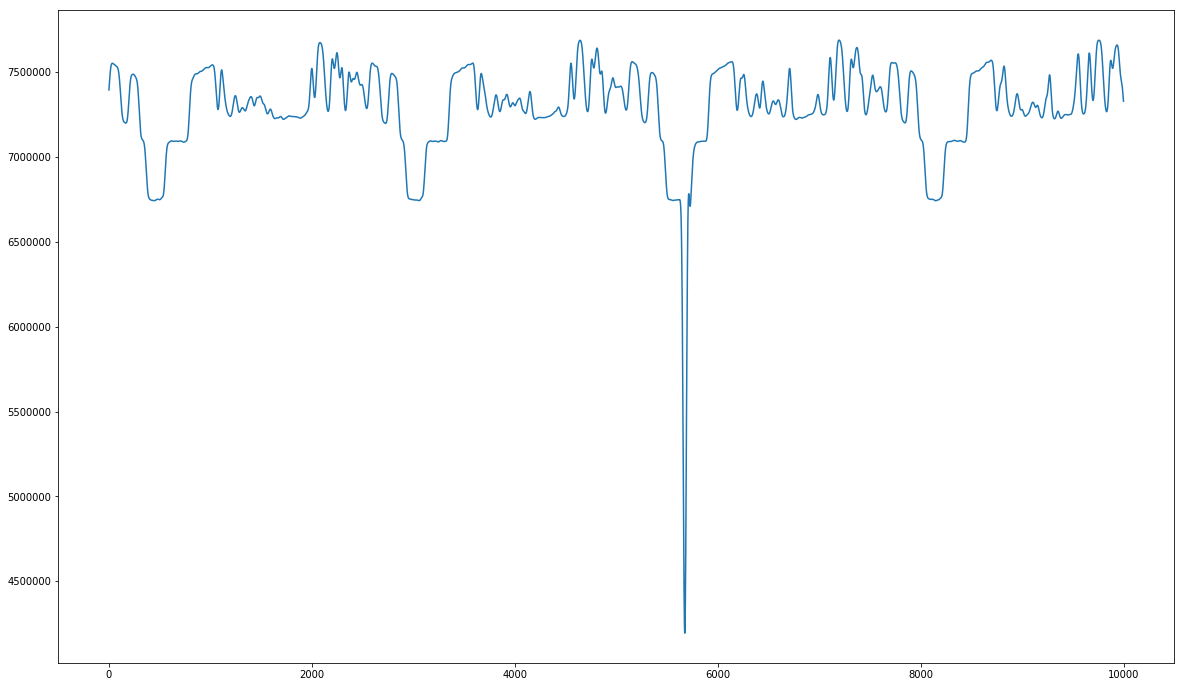

In [36]:
plt.plot(fi.data[0]['demod_05'][560000:570000])

In [40]:
np.argmax(np.diff(ll))

8

In [20]:
def refine_linelocs_pilot(self, linelocs = None):
    if linelocs is None:
        linelocs = self.linelocs2.copy()
    else:
        linelocs = linelocs.copy()

    pilots = []
    alloffsets = []
    offsets = {}

    # first pass: get median of all pilot positive zero crossings
    for l in range(len(linelocs)):
        pilot = self.data[0]['demod'][int(linelocs[l]-self.usectoinpx(4.7)):int(linelocs[l])].copy()
        pilot -= self.data[0]['demod_05'][int(linelocs[l]-self.usectoinpx(4.7)):int(linelocs[l])]
        pilot = np.flip(pilot)

        pilots.append(pilot)
        offsets[l] = []

        adjfreq = self.rf.freq
        if l > 1:
            adjfreq /= (linelocs[l] - linelocs[l - 1]) / self.rf.linelen

        i = 0

        while i < len(pilot):
            if inrange(pilot[i], -300000, -100000):
                zc = calczc(pilot, i, 0)

                if zc is not None:
                    zcp = zc / (adjfreq / 3.75)
                    #print(i, pilot[i], zc, zcp, np.round(zcp) - zcp)

                    offsets[l].append(zcp - np.floor(zcp))

                    i = np.int(zc + 1)

            i += 1

        if len(offsets) >= 3:
            offsets[l] = offsets[l][1:-1]
            if i >= 11:
                alloffsets += offsets[l]
        else:
            offsets[l] = []

    medianoffset = np.median(alloffsets)
    #print(medianoffset)
    if inrange(medianoffset, 0.25, 0.75):
        tgt = .5
    else:
        tgt = 0

    for l in range(len(linelocs)):
        if offsets[l] != []:
            #print(l, np.median(offsets[l]), tgt - np.median(offsets[l]))
            adjustment = tgt - np.median(offsets[l])
            linelocs[l] += adjustment * (self.rf.freq / 3.75) * .25

    return linelocs    

ll = refine_linelocs_pilot(fi)

(355255,)
uint8 (313, 1135) (313, 1135)


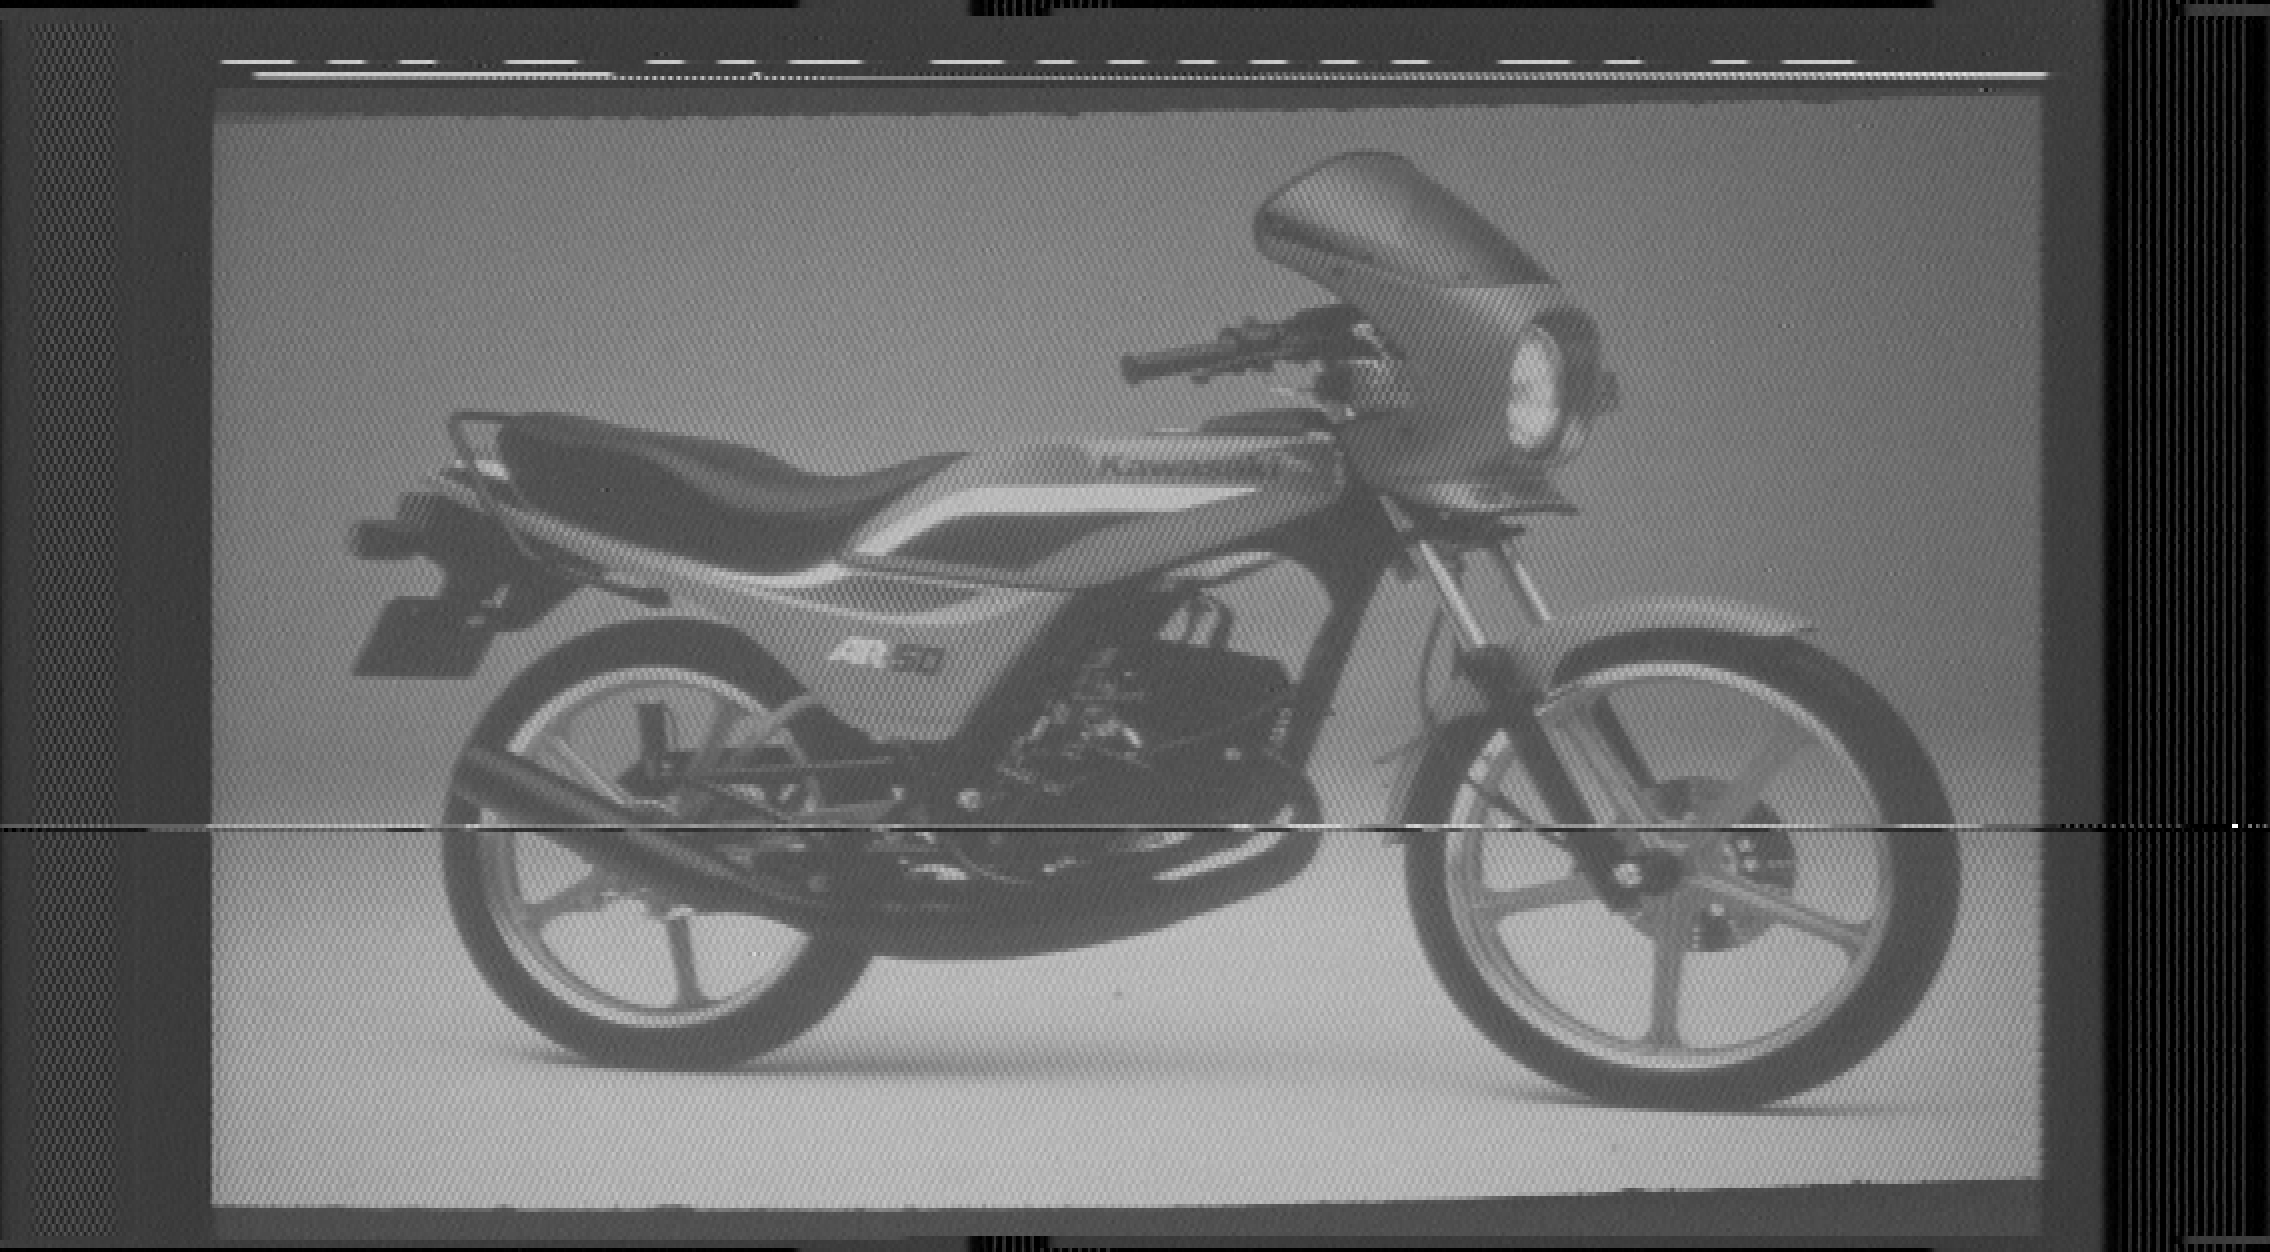

In [21]:
#fi.vsyncs

#ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
ds1 = self.downscale(lineinfo=ll, wow=True)[0]
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

In [430]:
calczc(self.data[0]['demod_05'], 43100, self.rf.iretohz(-20), reverse=False, _count=400)

43143.13418960158

In [ ]:
plt.plot(self.data[0]['demod_sync'][int(self.linelocs1[9]):int(self.linelocs1[14])])plt.plot(self.data[0]['demod_sync'][int(self.linelocs1[9]):int(self.linelocs1[14])])

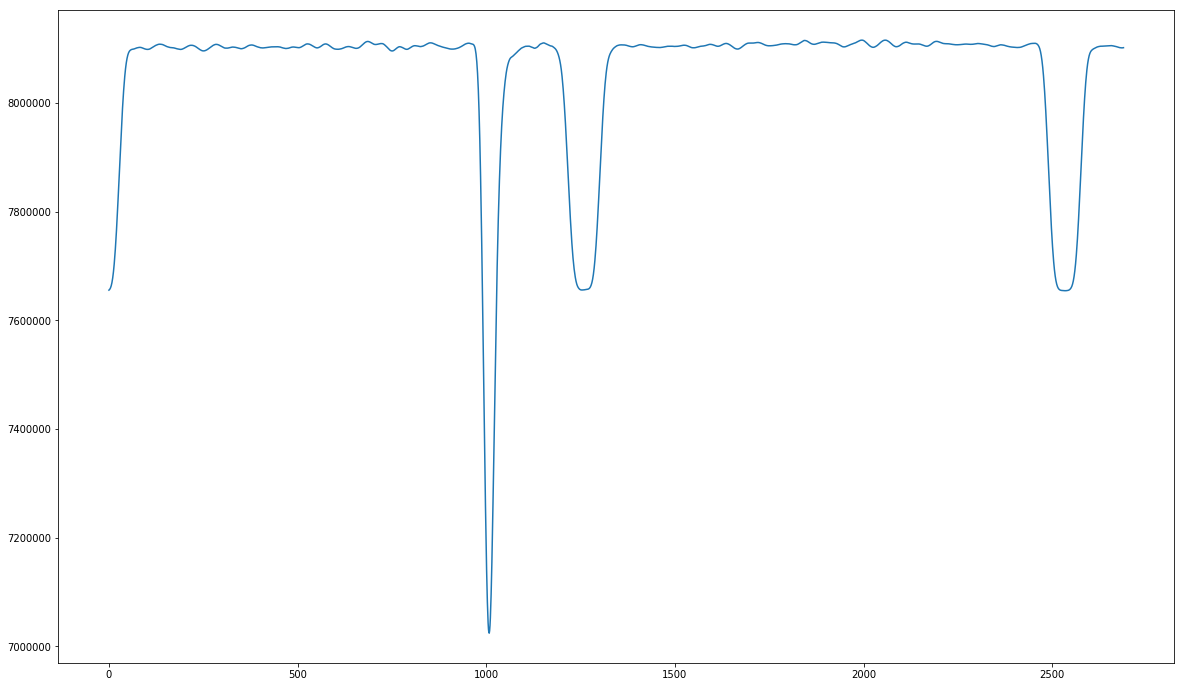

In [424]:
plt.plot(self.data[0]['demod_05'][43200:45890])

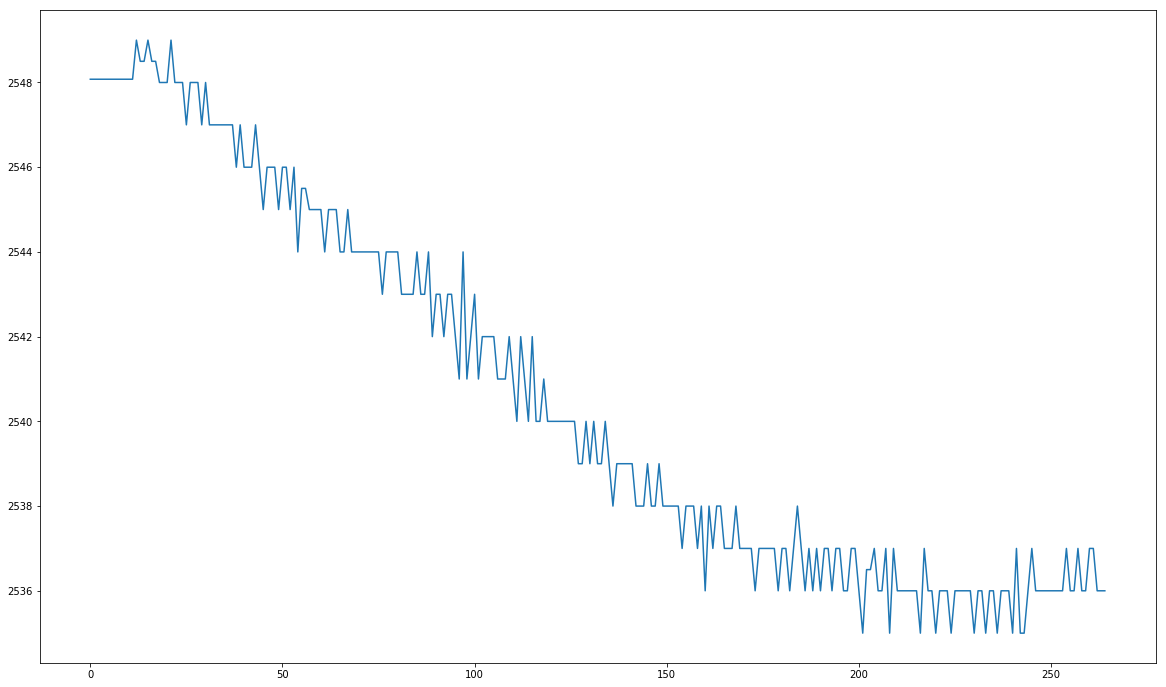

In [400]:
plt.plot(np.diff(self.linelocs1))
#plt.plot(np.diff(rv[0]))

In [337]:
def determine_field(self, peaknum):
    if peaknum < 11:
        return None
    
    vote = 0

    ds = self.data[0]['demod_sync']    

    # Determine first/second field
    # should this rely on what comes *after* the vsync too?
    line0 = None
    gap1 = None
    for i in range(peaknum - 1, peaknum - 20, -1):
        if self.is_regular_hsync(i) and line0 is None:
            line0 = i
            gap1 = (self.peaklist[line0 + 1] - self.peaklist[line0])
            break

    if gap1 is not None and gap1 > (self.inlinelen * .75):
        vote -= 1
            
    linee = None
    gap2 = None
    for i in range(peaknum, peaknum + 20, 1):
        plevel = self.data[0]['demod_sync'][self.peaklist[i]]
        print(i, self.peaklist[i], plevel)
        if self.is_regular_hsync(i)  and linee is None:
            linee = i
            gap2 = (self.peaklist[linee] - self.peaklist[linee - 1])
            break
    
    if gap2 is not None and gap2 > (self.inlinelen * .75):
        vote += 1
        
    print(line0, self.peaklist[line0], linee, gap1, gap2, vote)

    return line0, vote

determine_field(fi, 17)

17 36411 0.9997733473686313
18 37680 0.9998222195458785
19 38946 0.9998179832582574
20 40213 0.9998176057219461
21 41480 0.9998194070098413
22 42747 0.9998176057898346
23 44284 0.4167646142158745
24 45552 0.4167587193582637
25 46820 0.4121905646341665
26 48089 0.41675835045972054
27 49357 0.41219055733787635
28 50723 0.727570451093336
10 25363 28 2441 1366 -1


(10, -1)

In [315]:
va = np.array(fi.vsyncs)

In [322]:
va

array([[  18,   10,    1],
       [ 288,  281,    1],
       [ 559,  551,    1],
       [ 829,  822,    1],
       [1100, 1093,    0]])

In [321]:
va[4][2] == True

False

In [263]:
fi.peaklist[10+250:10+260]

[640952,
 643492,
 646032,
 648571,
 651110,
 653650,
 656189,
 658729,
 661269,
 663809]

In [271]:
self.peaklist[281]

694634

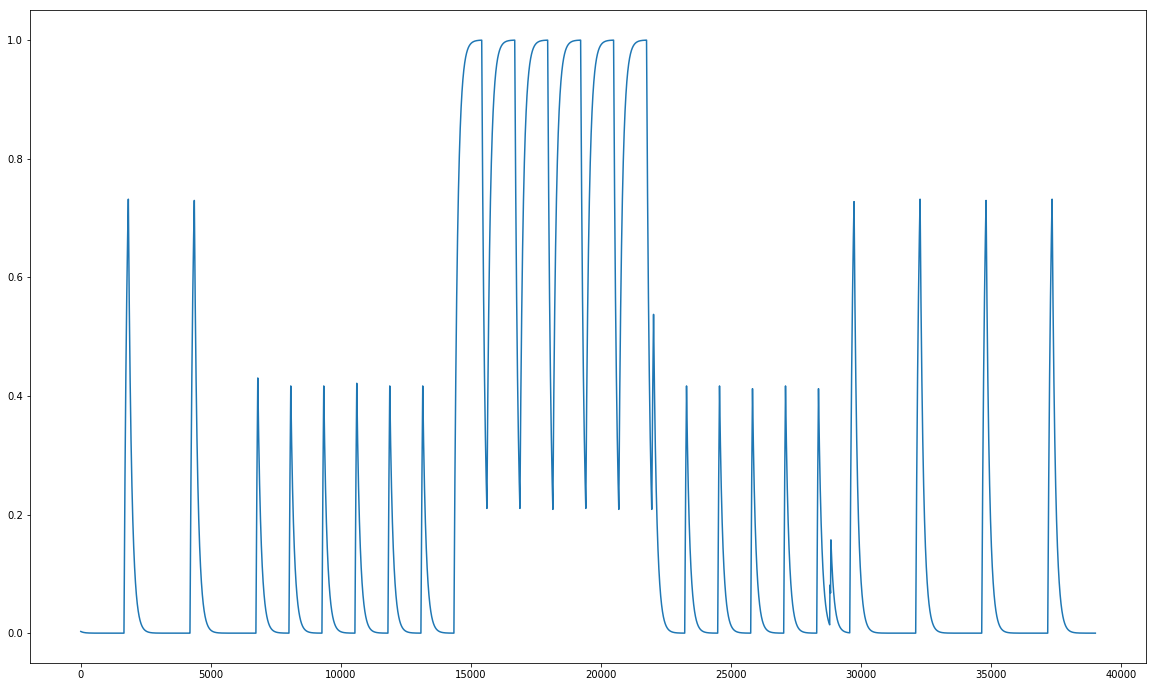

In [326]:
self = fi

ds = self.data[0]['demod_sync']
plist = self.peaklist
plevel = [ds[p] for p in self.peaklist]

plt.plot(ds[21000:60000])

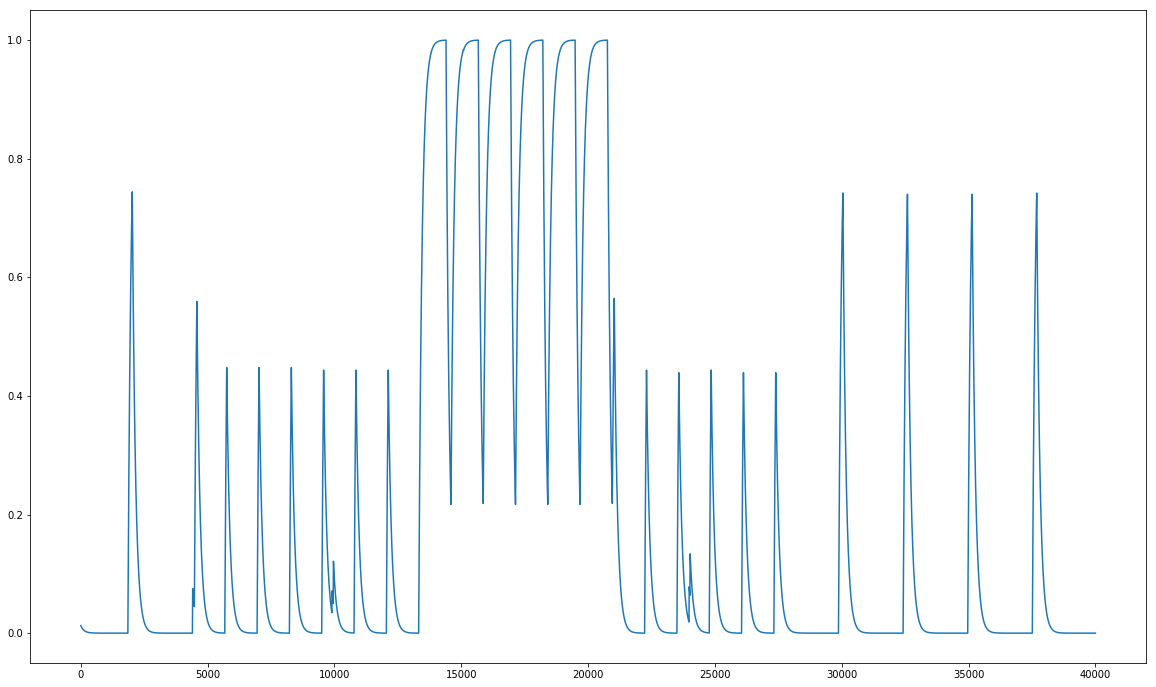

In [332]:
self = fi

ds = self.data[0]['demod_sync']
plist = self.peaklist
plevel = [ds[p] for p in self.peaklist]

plt.plot(ds[690000:730000])

In [65]:
def compute_linelocs(self):
    ds = self.data[0]['demod_sync']

    plist = self.peaklist
    plevel = [ds[p] for p in self.peaklist]

    plevel_hsync = [ds[p] for p in self.peaklist if inrange(ds[p], 0.6, 0.8)]
    med_hsync = np.median(plevel_hsync)
    std_hsync = np.std(plevel_hsync)

    hsync_tolerance = max(np.std(plevel_hsync) * 1.5, .01)
    print(med_hsync, hsync_tolerance)

    # note: this is chopped on output, so allocating too many lines is OK
    linelocs = {}

    linelens = [self.inlinelen]
    prevlineidx = None
    for i in range(0, self.vsyncs[1][1]): #self.vsyncs[1][1]):
        #print(i, plevel[i])
        med_linelen = np.median(linelens[-25:])
        
        if (inrange(plevel[i], med_hsync - hsync_tolerance, med_hsync + hsync_tolerance)):
            if prevlineidx is not None:
                linegap = plist[i] - plist[prevlineidx]
                
                if inrange(linegap / self.inlinelen, .98, 1.02):
                    linelens.append(linegap)
                    linenum = prevlinenum + 1
                else:
                    linenum = prevlinenum + int(np.round((plist[i] - plist[prevlineidx]) / med_linelen))
            else:
                linenum = int(np.round((plist[i] - plist[self.vsyncs[0][1]]) / med_linelen))


            linelocs[linenum] = plist[i]
            
            prevlineidx = i
            prevlinenum = linenum

            print(linenum, plist[i], plevel[i], plist[i] - plist[i - 1], ((plist[i] - plist[self.vsyncs[0][1]]) / med_linelen), med_linelen)

    linelocs2 = copy.deepcopy(linelocs)

    for l in range(1, self.linecount + 5):
        if l not in linelocs:
            prev_valid = None
            next_valid = None

            for i in range(l, -10, -1):
                if i in linelocs:
                    prev_valid = i
                    break
            for i in range(l, self.linecount + 1):
                if i in linelocs:
                    next_valid = i
                    break

            if next_valid is not None:
                avglen = (linelocs[next_valid] - linelocs[prev_valid]) / (next_valid - prev_valid)
                print(prev_valid, next_valid, avglen)
                linelocs2[l] = linelocs[prev_valid] + (avglen * (l - prev_valid))
            else:
                avglen = linelocs[prev_valid] - linelocs2[prev_valid - 1]
                linelocs2[l] = linelocs[prev_valid] + (avglen * (l - prev_valid))

            #print(l, linelocs2[l] - linelocs2[l - 1], avglen, linelocs2[l], linelocs[10], prev_valid, next_valid)

    rv = [linelocs2[l] for l in range(1, self.linecount + 5)]
    return rv

ll = compute_linelocs(fi)

0.7358570924280411 0.014500381570909219
-10 0 0.731748411687644 -2994531 -9.976789929189614 2542.0
-9 2535 0.7316726917441057 2535 -8.979543666404407 2542.0
-8 5072 0.7337718967141098 2537 -7.992515264920229 2538.5
-7 7607 0.7295569345497244 2535 -6.998029168309026 2537.0
-6 10143 0.7295569345272783 2536 -6.000788643533123 2536.0
-5 12679 0.731672691726224 2536 -5.000788643533123 2536.0
-4 15215 0.7316726917309566 2536 -4.000788643533123 2536.0
-3 17752 0.7316726917181267 2537 -3.0003943217665614 2536.0
-2 20287 0.7316726917439373 2535 -2.0007886435331232 2536.0
-1 22824 0.7316726917180826 2537 -1.0003943217665616 2536.0
0 25361 0.7316726917180814 2537 0.0 2536.0
10 50718 0.7274338688272052 1364 9.998817034700316 2536.0
11 53256 0.7295569344970214 2538 10.999605678233438 2536.0
12 55793 0.727424494598677 2537 11.997634535777646 2536.5
13 58331 0.7316726916959483 2538 12.995664170279857 2537.0
14 60869 0.7316726917053045 2538 13.996058336618052 2537.0
15 63406 0.7295569345193157 2537 14

185 187 2548.5
228 230 2560.0
236 239 2547.3333333333335
236 239 2547.3333333333335
244 248 2548.25
244 248 2548.25
244 248 2548.25


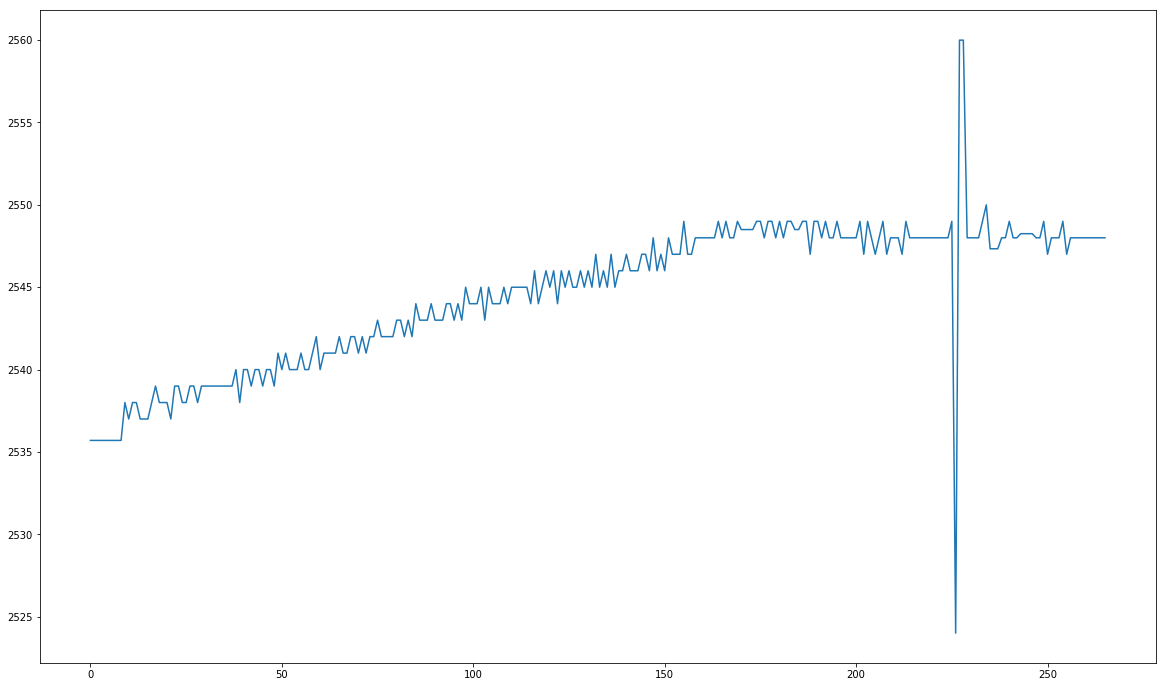

In [79]:
plt.plot(np.diff(ll))

(238420,)
uint8 (262, 910) (262, 910)


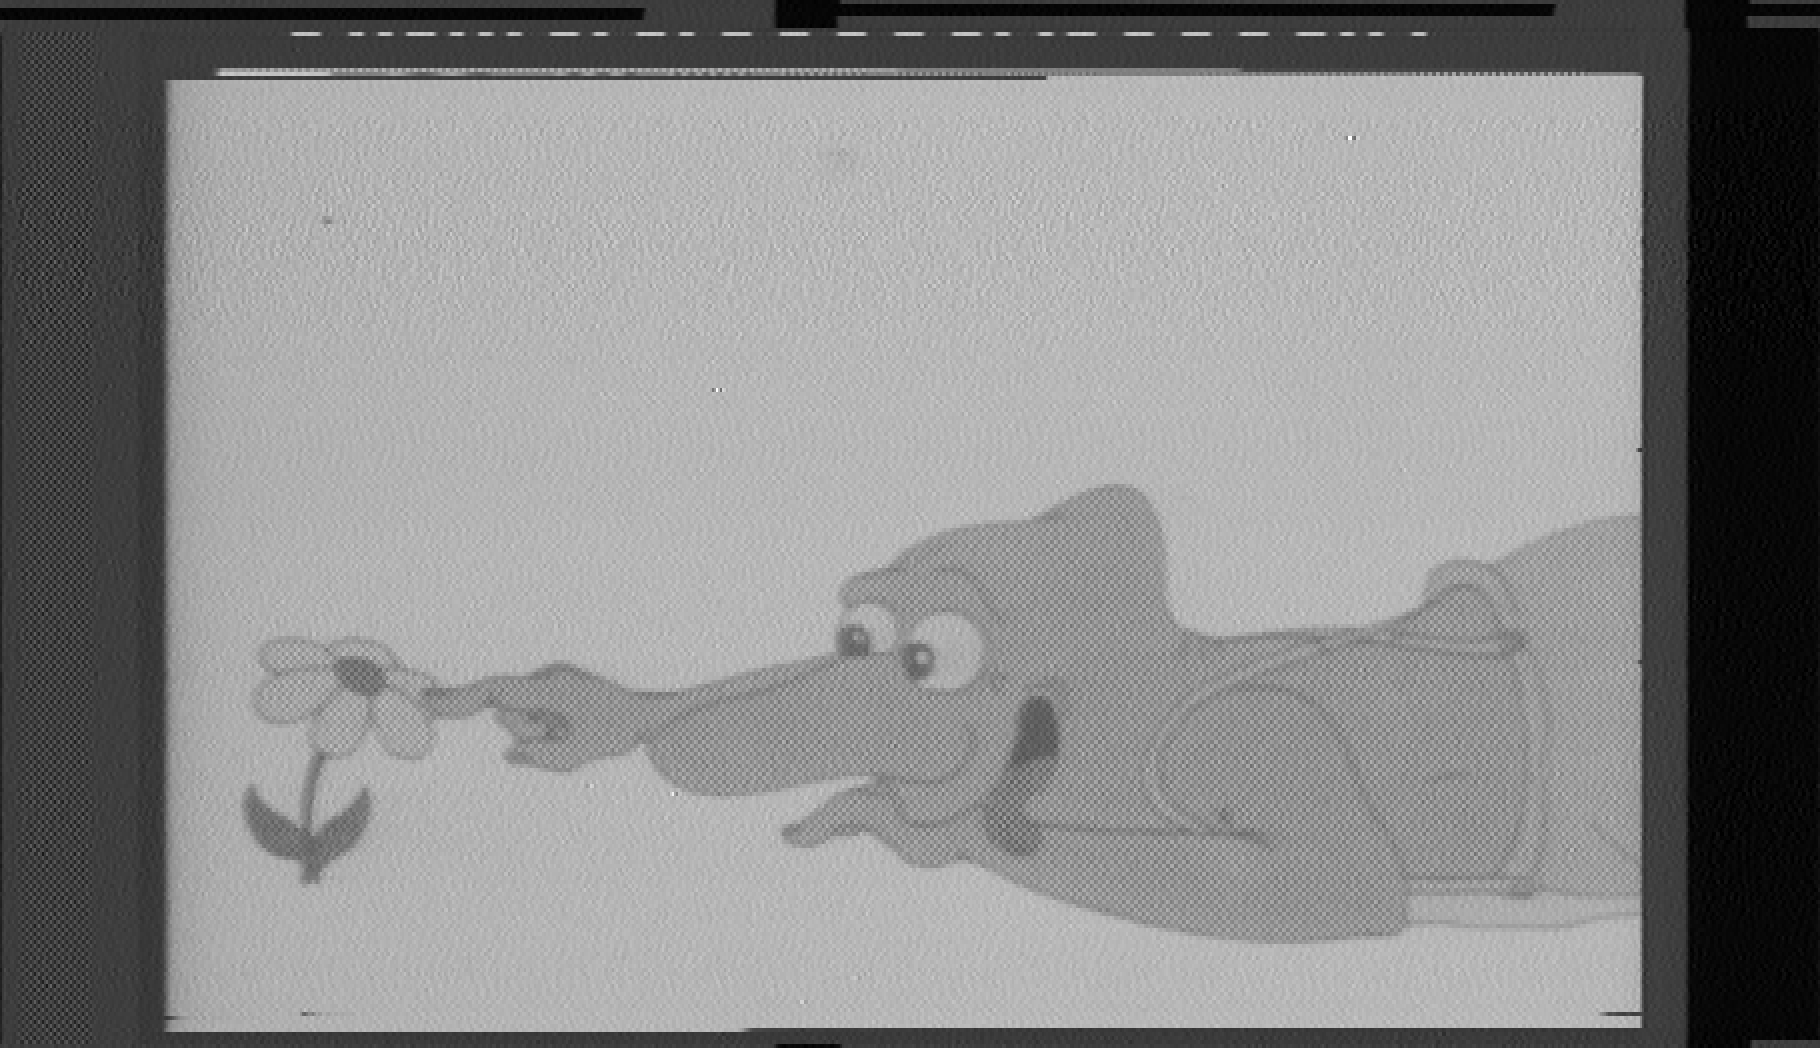

In [351]:
ds1 = fi.downscale(lineinfo=fi.linelocs2, wow=False)[0]
self = fi
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

In [67]:
np.argmin(np.diff(ll))

226

In [466]:
rf_pal = ldd.RFDecode(system='PAL', decode_analog_audio=False)
bytes_per_frame = int(rf_pal.freq_hz / rf_pal.SysParams['FPS'])
framer_pal = ldd.Framer(rf_pal)

infile_pal = open('/home/cpage/ddsftp/Domesday/Simon/LDV4300D_2 Captures/AIV/Domesday_DiscSet2/Domesday Community South_CAV_PAL_side2_Disc set 2_2018-10-02_17-21-20.lds', 'rb')
#infile_pal = open('/mnt3/', 'rb')
infile_pal = open('/home/cpage/Roger Rabbit Bonus disc_CAV_PAL_side1_1min_2018-10-17_16-21-21.lds', 'rb')
#infile_pal = open('/home/cpage/ldsamples.pal/PAL_ROTTER_NO_TIMECODE_1.lds', 'rb')
ldd.loader = load_packed_data_4_40

nextsample = 0

rawdecode = rf_pal.demod(infile_pal, nextsample, framer_pal.readlen * 2)

fi = ldd.FieldPAL(rf_pal, rawdecode, 0)

218 551499 540356


In [467]:
fi.vsyncs, fi.peaklist[514]

(array([[217, 211,   1],
        [536, 530,   0]]), 1301036)

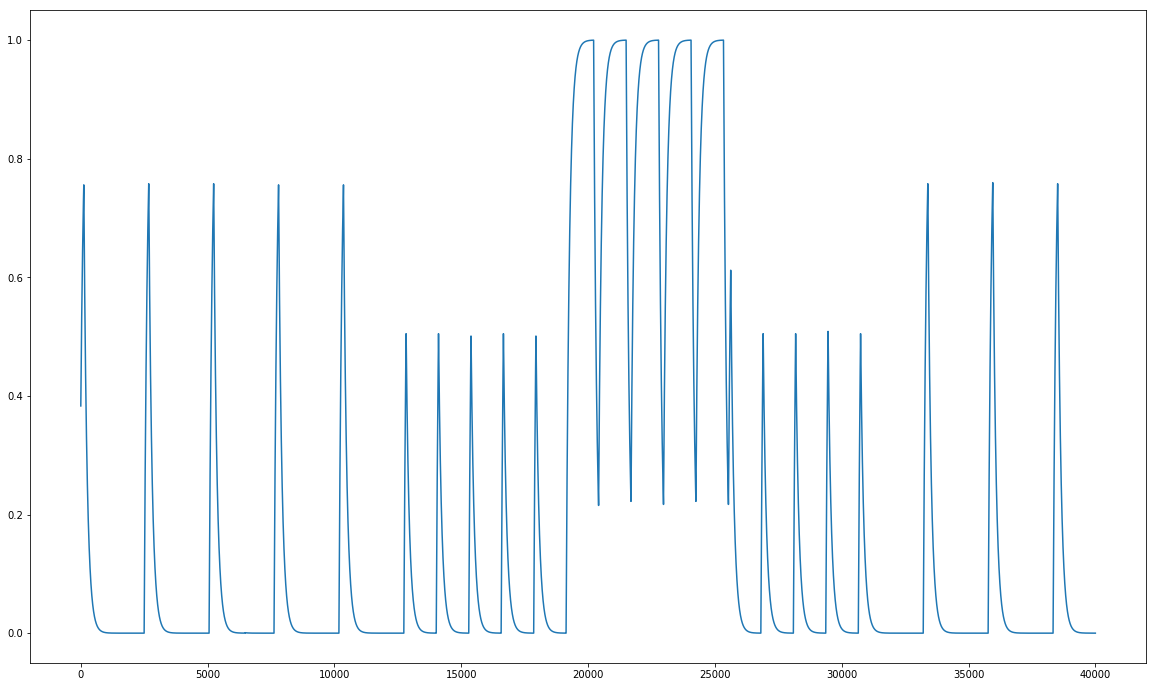

In [468]:
#plt.plot(fi.data[0]['demod_05'][550000:590000])
plt.plot(fi.data[0]['demod_sync'][530000:570000])

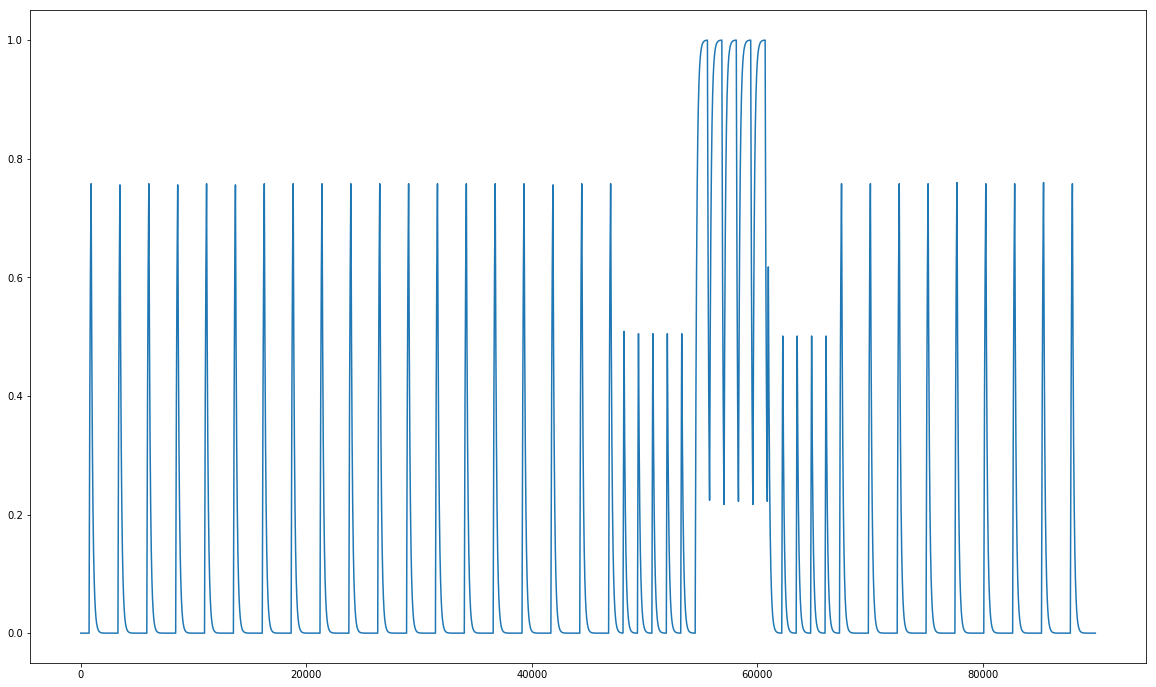

In [465]:
#plt.plot(fi.data[0]['demod_05'][550000:590000])
plt.plot(fi.data[0]['demod_sync'][1295000:1385000])

(355255,)
uint8 (313, 1135) (313, 1135)


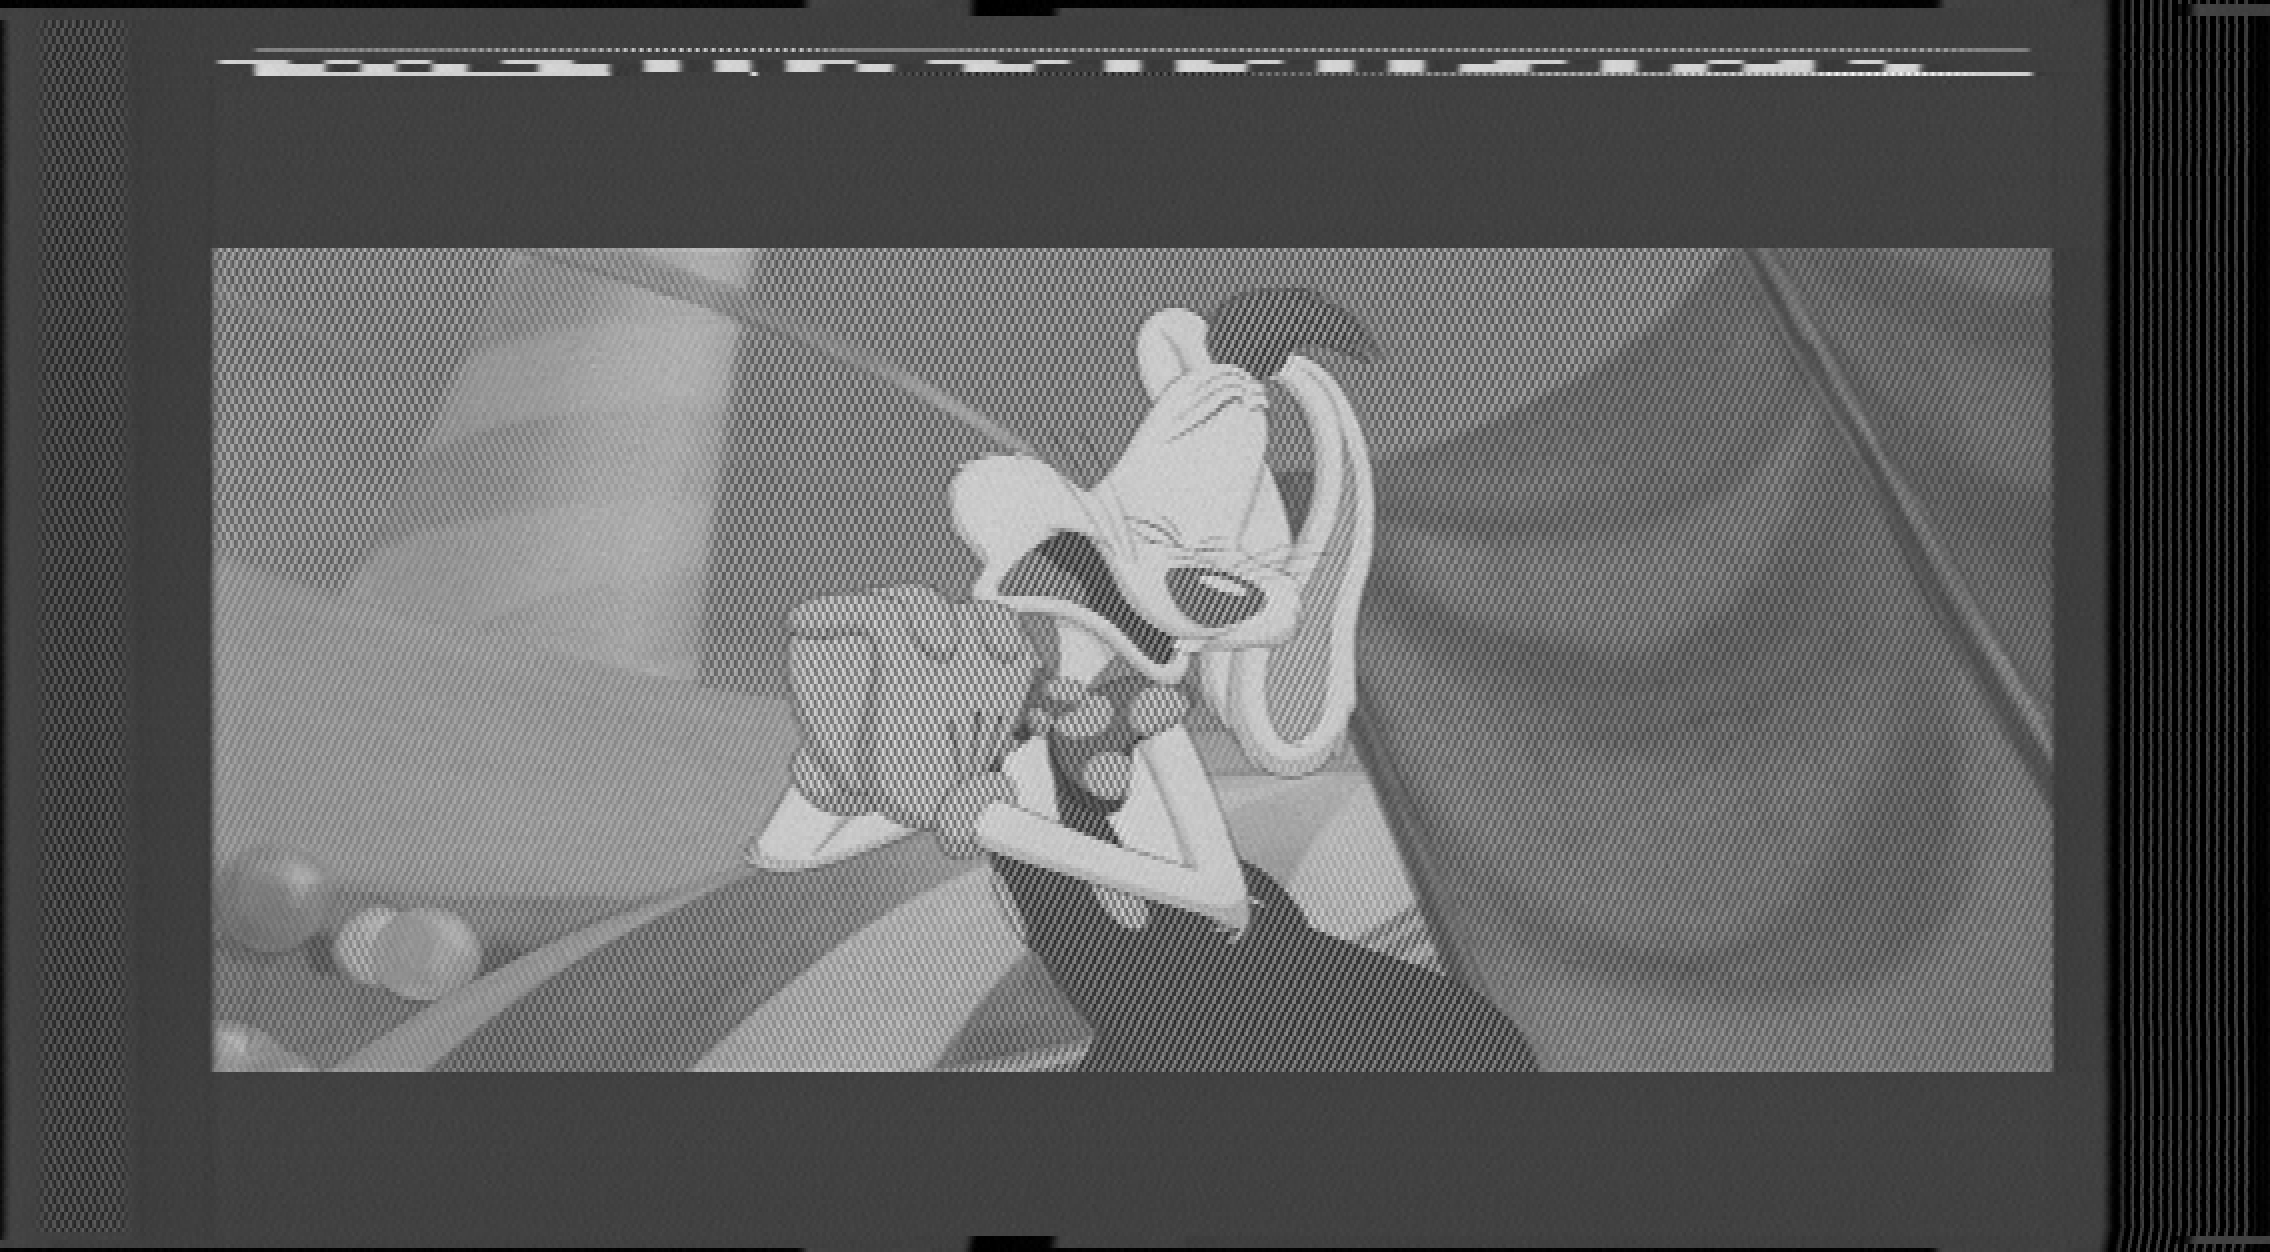

In [469]:
ds1 = fi.downscale(lineinfo=fi.linelocs1)[0]
self = fi
reduced = (ds1 - self.rf.SysParams['ire0']) / self.rf.SysParams['hz_ire']
reduced -= self.rf.SysParams['vsync_ire']
out_scale = np.double(0xc800 - 0x0400) / (100 - self.rf.SysParams['vsync_ire'])
lines16 = np.uint16(np.clip((reduced * out_scale) + 1024, 0, 65535) + 0.5) 
draw_raw_bwimage(lines16, self.rf.SysParams['outlinelen'], self.linecount, hscale=2, vscale=4)

In [217]:
RFParams_PAL_test = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 200000,
    'audio_notchorder': 2,

    'video_deemp': (100*.32, 400*.32),

    # XXX: guessing here!
    'video_bpf': (2600000, 12500000),
    'video_bpf_order': 3,

    'video_lpf_freq': 4800000,
    'video_lpf_order': 5,
}

rf_pal.DecoderParams = copy.deepcopy(RFParams_PAL_test)
rf_pal.computevideofilters()
rawdecode = rf_pal.demod(infile_pal, nextsample, framer_pal.readlen * 1)

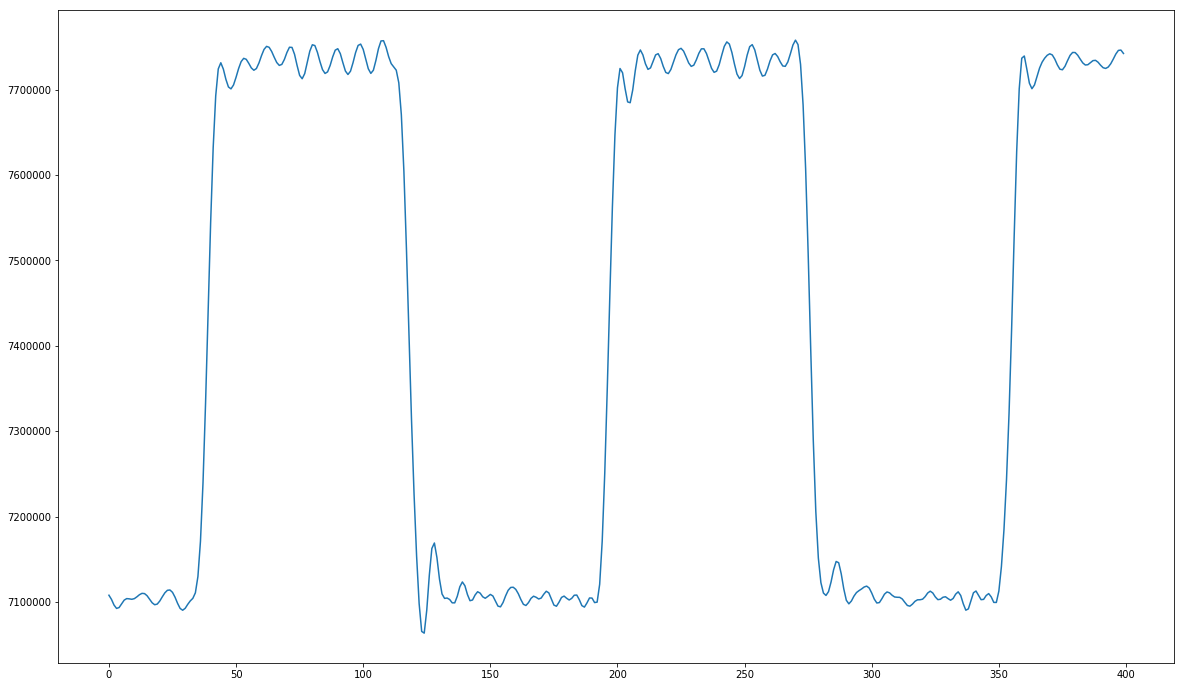

In [218]:
plt.plot(rawdecode[0]['demod'][int(fi.linelocs2[114]+1000):int(fi.linelocs2[114]+1400)])

In [234]:
d2 = rawdecode[0]['demod'][int(fi.linelocs2[114]+1000):int(fi.linelocs2[114]+1400)]

In [208]:
RFParams_PAL_test = {
    # The audio notch filters are important with DD v3.0+ boards
    'audio_notchwidth': 200000,
    'audio_notchorder': 2,

    'video_deemp': (100*.34, 400*.34),

    # XXX: guessing here!
    'video_bpf': (2500000, 12500000),
    'video_bpf_order': 1,

    'video_lpf_freq': 4800000,
    'video_lpf_order': 8,
}

rf_pal.DecoderParams = copy.deepcopy(RFParams_PAL_test)
rf_pal.computevideofilters()
rawdecode = rf_pal.demod(infile_pal, nextsample, framer_pal.readlen * 1)
#plt.plot(d1)
plt.plot(rawdecode[0]['demod'][int(fi.linelocs2[114]+1000):int(fi.linelocs2[114]+1400)])


TypeError: 'NoneType' object is not subscriptable

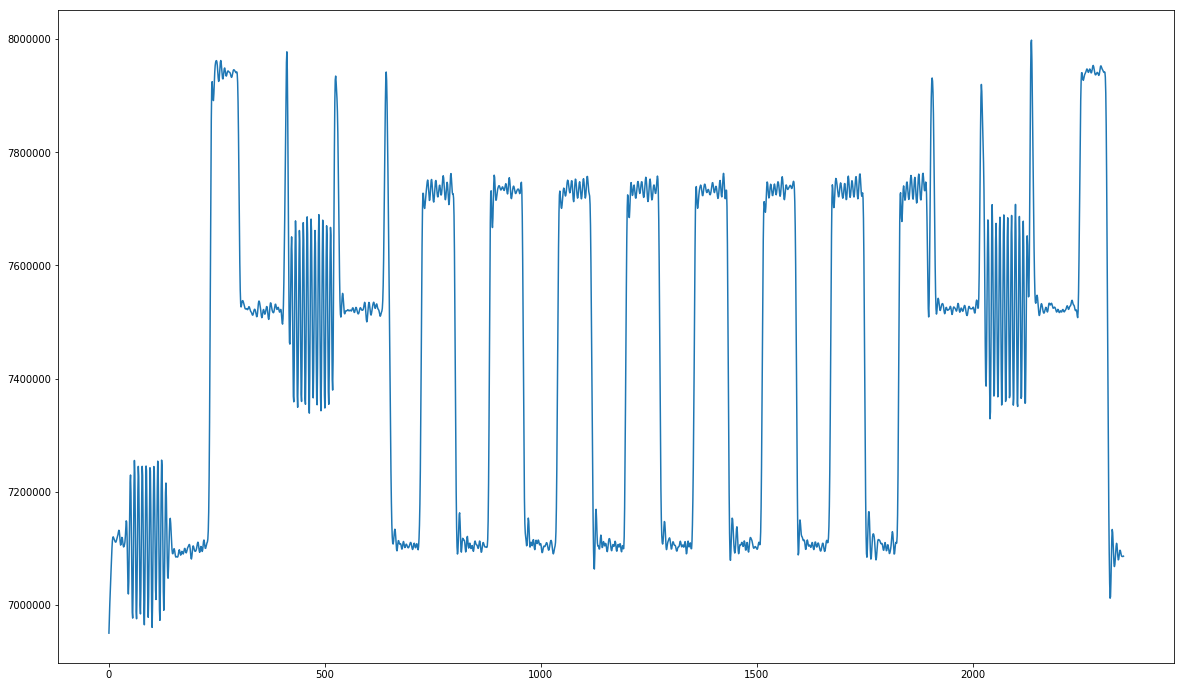

In [170]:
plt.plot(rawdecode[0]['demod'][int(fi.linelocs2[114]):int(fi.linelocs2[114]+2350)])

(355255,)
uint8 (313, 1135) (313, 1135)


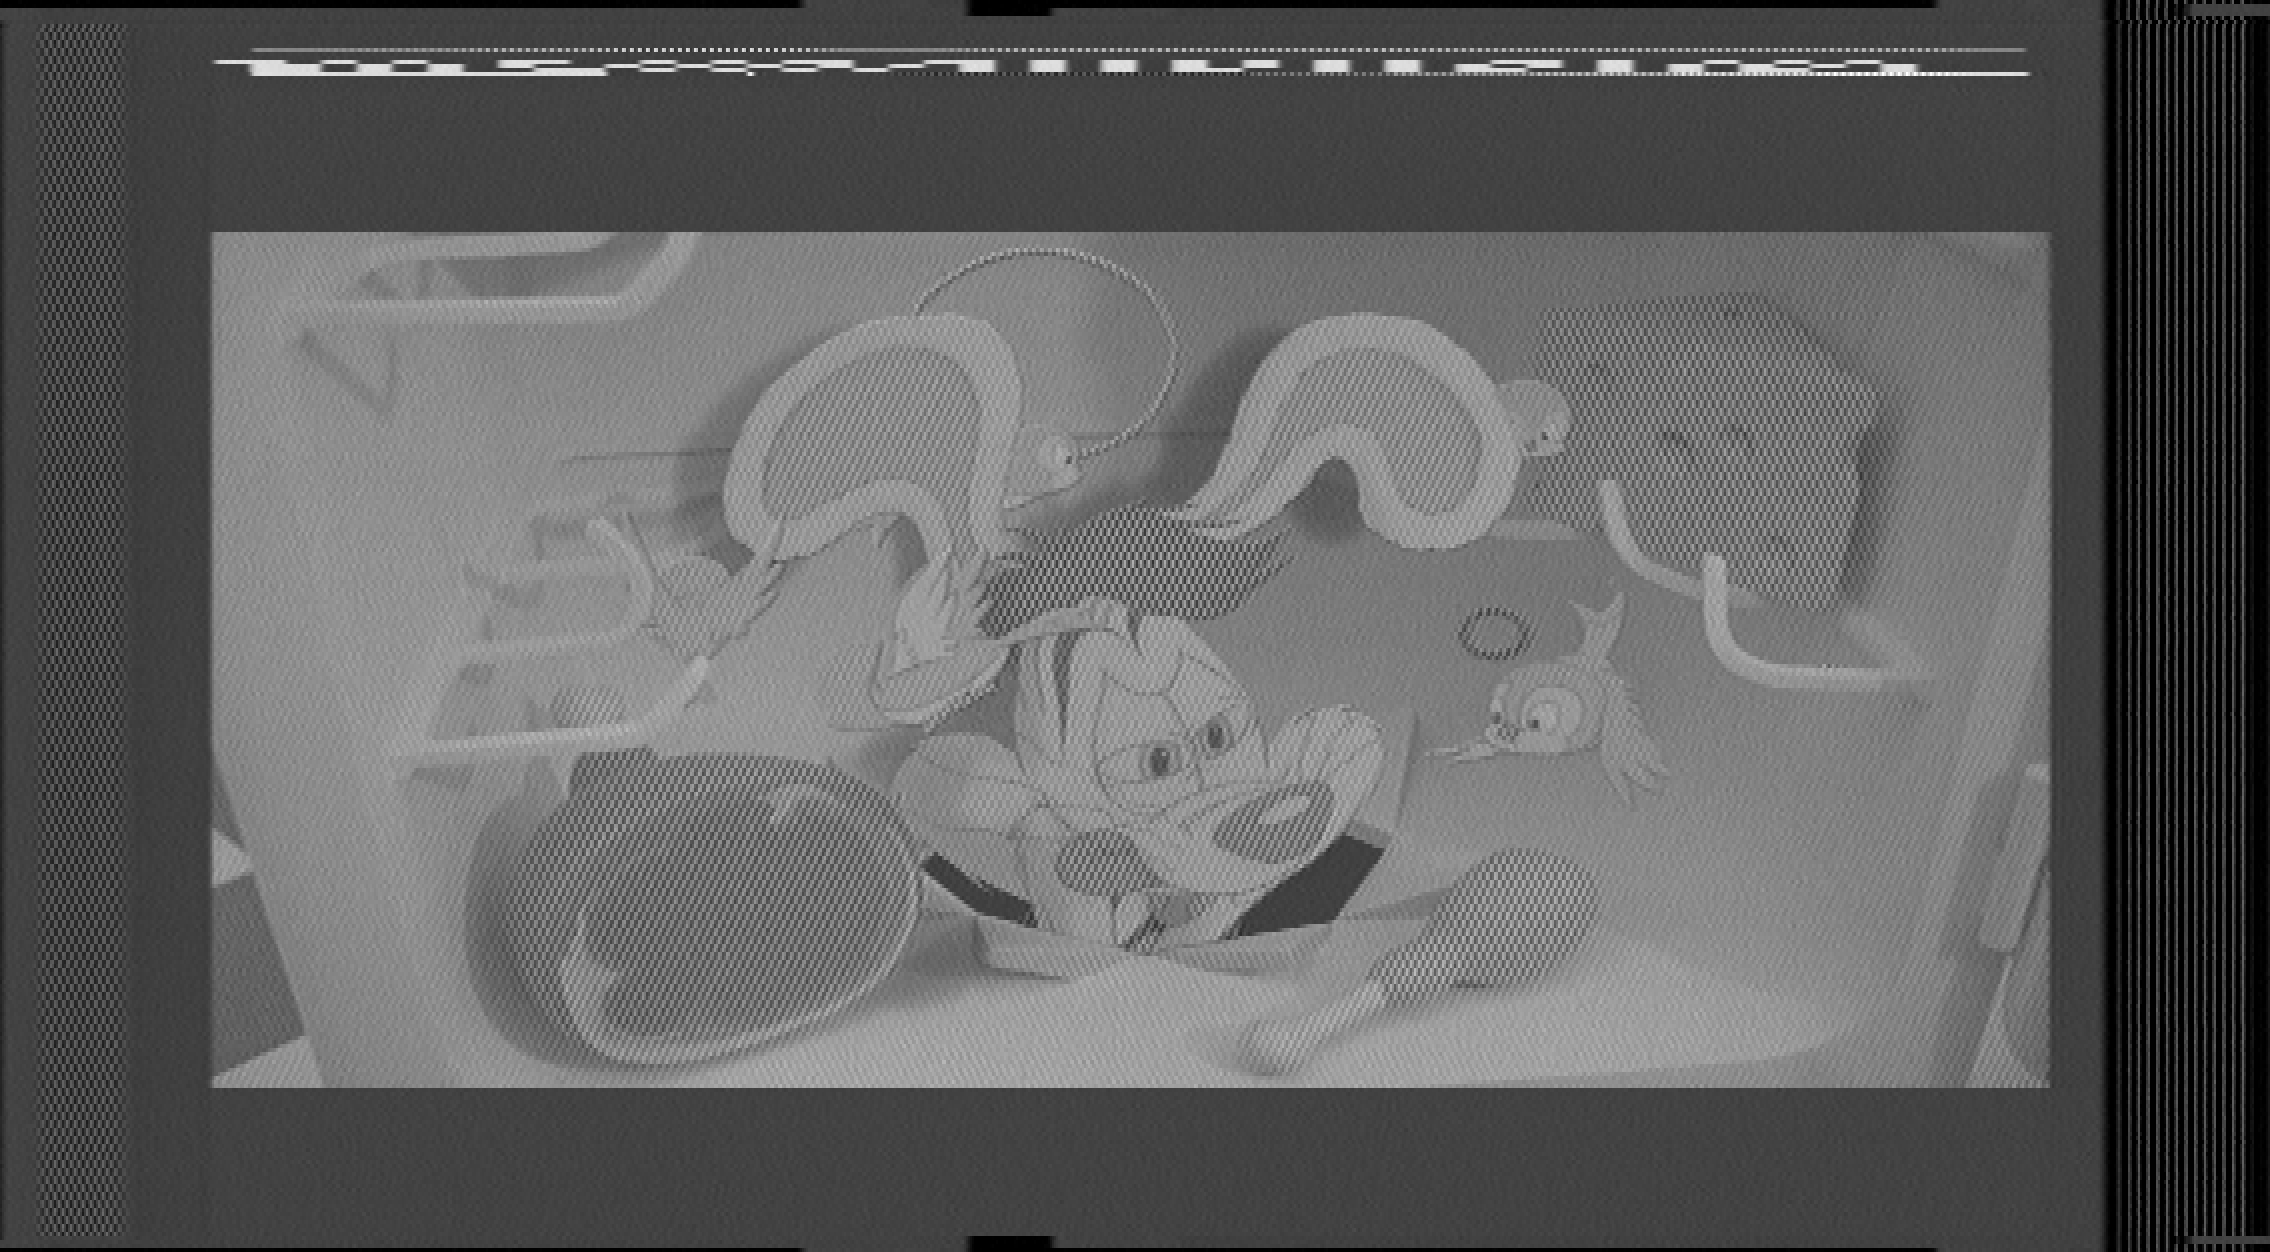

In [7]:
f = framer_pal.FieldClass(rf_pal, rawdecode, 0)

ds1 = f.downscale(final=True)[0]
draw_raw_bwimage(ds1, f.rf.SysParams['outlinelen'], f.linecount, hscale=2, vscale=4)